# ЗАДАЧА 5
ПОИСК ОДИНАКОВЫХ ТОВАРОВ НА МАРКЕТПЛЕЙСЕ

АКТУАЛЬНОСТЬ

Ozon — ведущая мультикатегорийная платформа электронной коммерции и одна из крупнейших интернет-компаний в России. На площадке представлено более 150 млн товарных наименований в 20 категориях: от книг и одежды до продуктов питания и товаров для здоровья.

Сейчас более 90% ассортимента площадки формируют партнеры маркетплейса, в некоторых случаях предлагающие одинаковые товары по разной стоимости и с разными сроками доставки.

В этой связи Ozon нужно постоянно совершенствовать алгоритм определения одинаковых товаров, чтобы клиенты лучше ориентировались в предложениях продавцов

ОПИСАНИЕ ЗАДАЧИ
Разработайте ML-модель, способную определить идентичность товаров по названиям, атрибутам и изображениям.

Модель должна находить среди пар-кандидатов как можно больше одинаковых товаров с точностью >95%

РЕСУРСЫ
Тренировочная выборка: пары одинаковых и различных товаров;
Тестовая выборка: пары товаров без разметки (выборка для формирования лидерборда);
Дополнительные данные: названия, атрибуты, векторные представления картинок (эмбединги) товаров

ОПИСАНИЕ ИТОГОВОГО ПРОДУКТА
ML-модель

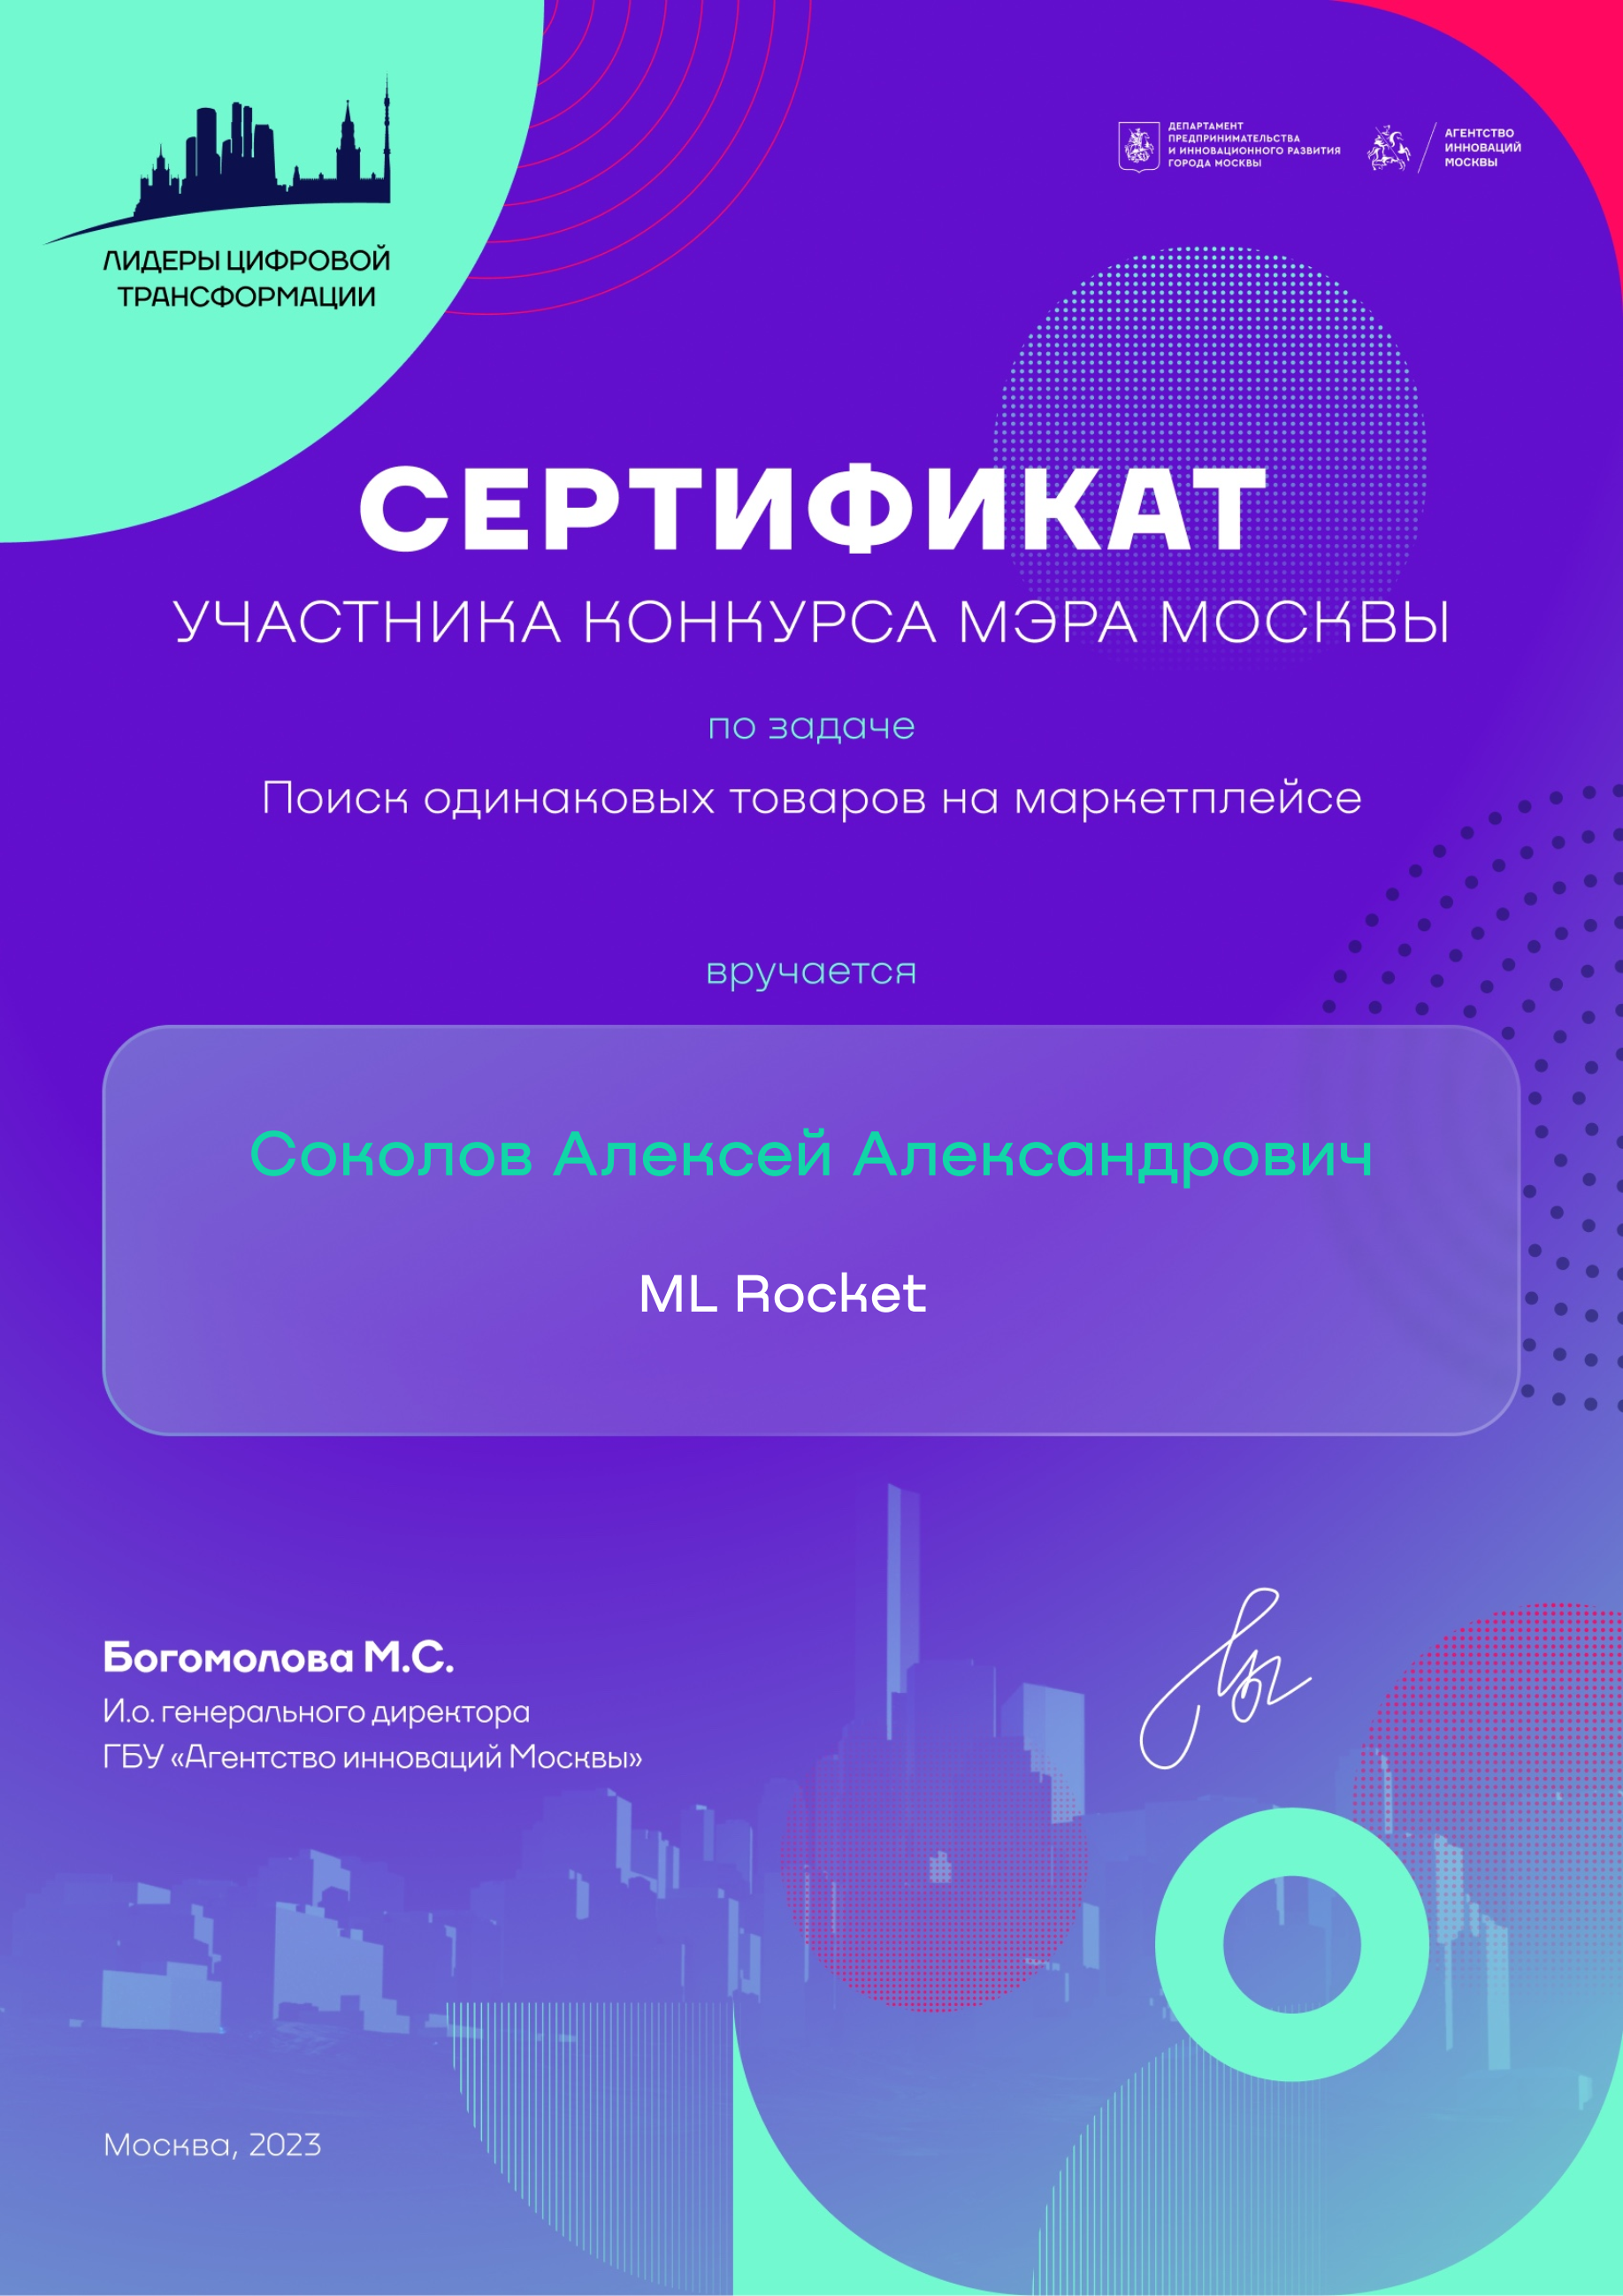

#Библиотеки

In [ ]:
from google.colab import files #для работы с файлами в Google Colab
from google.colab import drive #подключение Google-диска
import os #функционал для работы с операционной системой и файловой системой

import re #функционал для работы с регулярными выражениями
import json #функционал для работы с данными в формате JSON
import time #функционал для работы со временем
import datetime #функционал для работы с датами и временем
import math #функционал для работы с числами
import tarfile #для чтения и записи tar-архивов
import pickle #для сохранения и загрузки tokenizer'а
from collections import Counter #для подсчёта повторений уникальных атрибутов

import tensorflow as tf
import keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #для визуализации данных и диаграмм
import seaborn as sns #более высокоуровневый интерфейс для создания графиков
#команда для отображения графиков в блокнотах Jupyter и JupyterLab
%matplotlib inline

from keras import utils #утилита для работы с нейронными сетями
from keras.preprocessing.text import Tokenizer #для преобразования текстовых данных в числовые тензоры
from tensorflow.keras.preprocessing.sequence import pad_sequences #для заполнения последовательностей переменной длины нулями или обрезания их до заданной длины

from keras.models import Sequential, Model # для создания архитектур нейронных сетей
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Conv1D,  MaxPooling1D, Conv1DTranspose #слои
from keras.layers import concatenate, Input, Reshape #слои
from keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop #оптимизаторы

In [ ]:
# подключаем google-диск
drive.mount('/content/drive')

In [ ]:
#Загрузка датасетов
df_train = pd.read_parquet('/content/drive/MyDrive/hackathon_LCT/Output/df_train_red.parquet', engine='pyarrow').reset_index(drop=True)
df_test = pd.read_parquet('/content/drive/MyDrive/hackathon_LCT/Output/df_test_red.parquet', engine='pyarrow').reset_index(drop=True)
df_train_pairs = pd.read_parquet('/content/drive/MyDrive/hackathon_LCT/hackathon_files_for_participants_ozon/train_pairs.parquet', engine='pyarrow').reset_index(drop=True)
df_test_pairs_wo_target = pd.read_parquet('/content/drive/MyDrive/hackathon_LCT/hackathon_files_for_participants_ozon/test_pairs_wo_target_new.parquet', engine='pyarrow').reset_index(drop=True)

#Исследование данных

##df_train

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457063 entries, 0 to 457062
Data columns (total 8 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   variantid                           457063 non-null  int64 
 1   name                                457063 non-null  object
 2   categories                          457063 non-null  object
 3   color_parsed                        378652 non-null  object
 4   pic_embeddings_resnet_v1            303467 non-null  object
 5   main_pic_embeddings_resnet_v1       457063 non-null  object
 6   name_bert_64                        457063 non-null  object
 7   characteristic_attributes_mapping2  457063 non-null  object
dtypes: int64(1), object(7)
memory usage: 27.9+ MB


Представлены следующие данные (8 столбцов и 457063 строк):
* variantid - id товара
* name - наименование товара
* categories - категория товара
* color_parsed - цвет
* pic_embeddings_resnet_v1 - эмбендинги дополнительных изображений
* main_pic_embeddings_resnet_v1 - эмбендинги главного изображения
* name_bert_64 - текстовые эмбендинги (наименование товара)
* characteristic_attributes_mapping - атрибуты

In [ ]:
df_train.head()

variantid                                               name  \
0   51195767  Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...   
1   53565809  Магнитный кабель USB 2.0 A (m) - USB Type-C (m...   
2   56763357  Набор микропрепаратов Konus 25: "Клетки и ткан...   
3   56961772             Мобильный телефон BQ 1848 Step, черный   
4   61054740  Штатив трипод Tripod 330A для фотоаппаратов, в...   

                                          categories color_parsed  \
0  {"1": "EPG", "2": "Электроника", "3": "Сетевые...  [оранжевый]   
1  {"1": "EPG", "2": "Электроника", "3": "Кабели ...    [красный]   
2  {"1": "EPG", "2": "Электроника", "3": "Оптичес...         None   
3  {"1": "EPG", "2": "Электроника", "3": "Смартфо...     [черный]   
4  {"1": "EPG", "2": "Электроника", "3": "Штативы...     [черный]   

                            pic_embeddings_resnet_v1  \
0                                               None   
1  [[0.26863545, -0.3130674, 0.29023397, 0.073978...   
2  [[0.66954195, 1.0643557, 0.78324044, -0.338267...   
3  [[0.6580482, -0.35763323, -0.16939065, -0.4249...   
4  [[-0.10406649, 0.080646515, -0.28668788, 0.739...   

                       main_pic_embeddings_resnet_v1  \
0  [[0.04603629, 0.18839523, -0.09973055, -0.6636...   
1  [[1.1471839, -0.665361, 0.7745614, 0.26716197,...   
2  [[-0.90570974, 1.0296293, 1.0769907, 0.27746, ...   
3  [[0.13133773, -0.5577079, 0.32498044, 0.191717...   
4  [[0.21696381, 0.10989461, -0.08012986, 0.69186...   

                                        name_bert_64  \
0  [-0.47045058, 0.67237014, 0.48984158, -0.54485...   
1  [-0.6575592, 0.6522429, 0.5426037, -0.54347897...   
2  [-0.7384308, 0.70784587, 0.3012653, -0.3583719...   
3  [-0.44812852, 0.5283565, 0.28981736, -0.506841...   
4  [-0.72692573, 0.75206333, 0.37740713, -0.52502...   

                  characteristic_attributes_mapping2  
0  {"Номинальный ток, А":["10"],"Цвет товара":["о...  
1  {"Конструктивные особенности":["Магнитная конс...  
2  {"Тип аксессуара":["Набор микропрепаратов"],"Б...  
3  {"Тип карты памяти":["microSD"],"Число SIM-кар...  
4  {"Материал":["Металл"],"Количество секций, шт"...

###Визуализируем пропуски

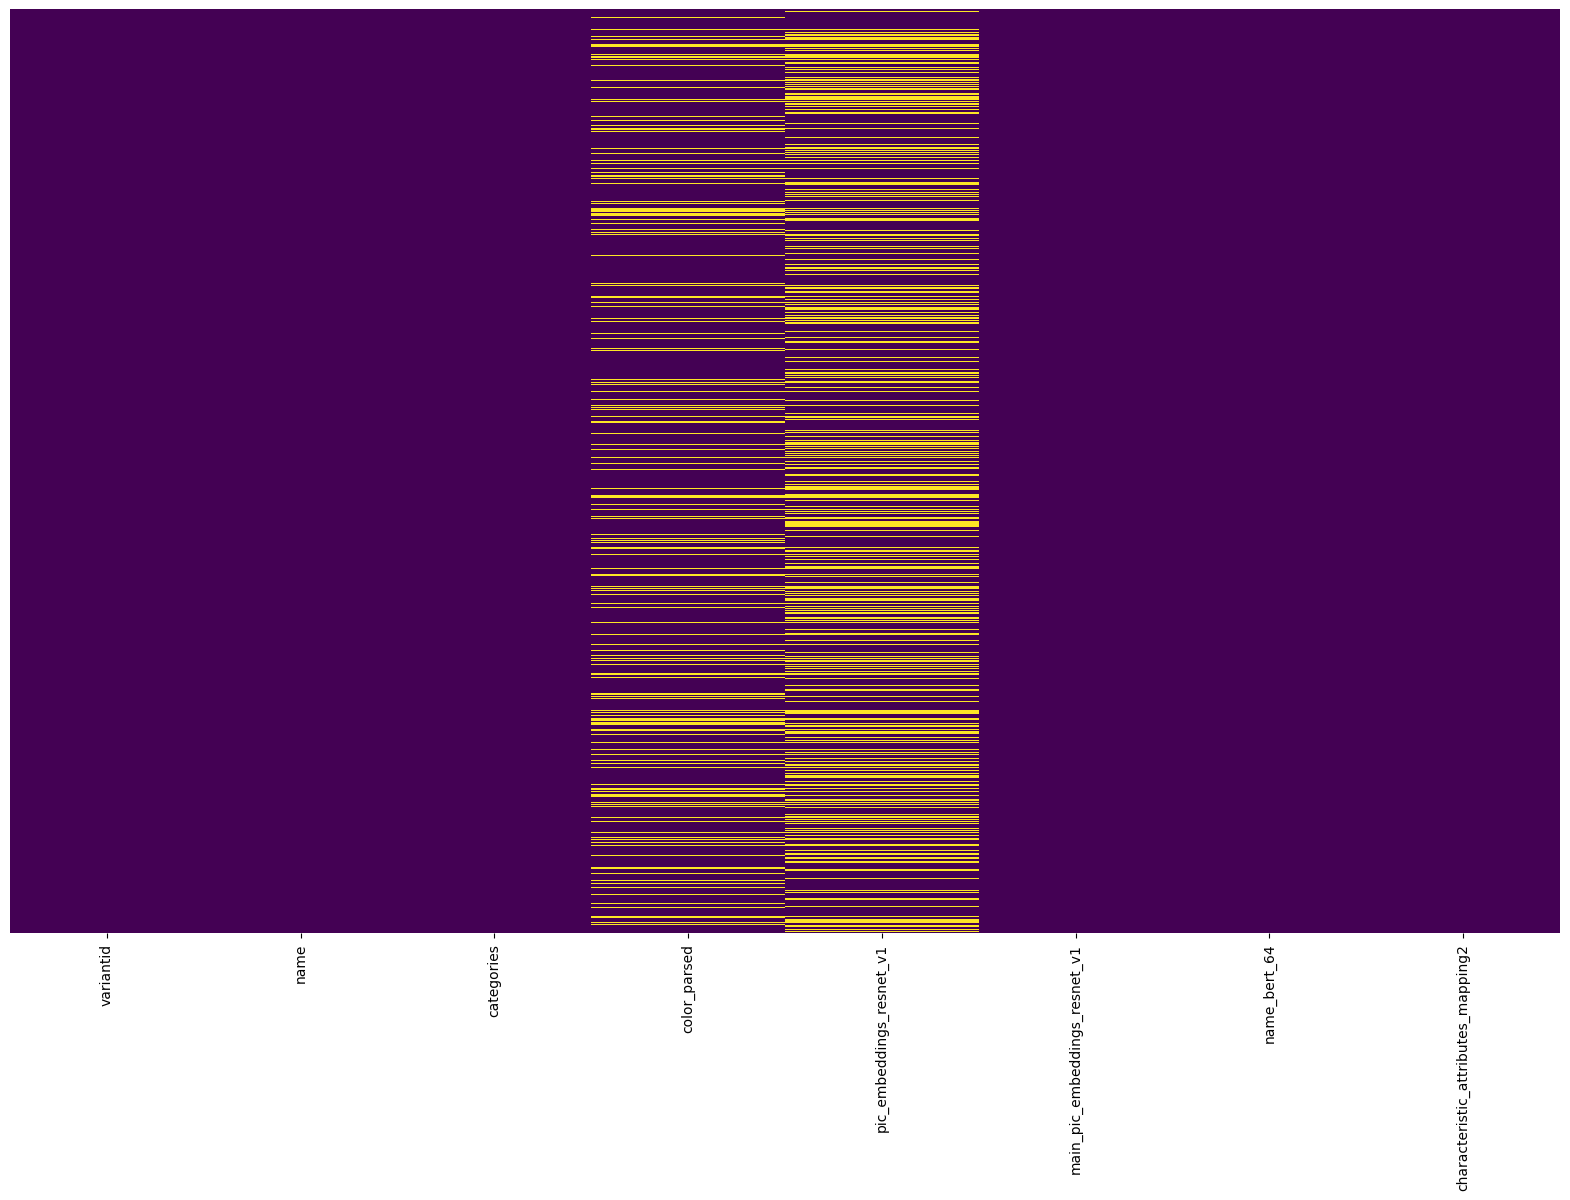

In [ ]:
fig, ax = plt.subplots(figsize=(20,12)) # Создаем область под график
sns_heatmap = sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='viridis') #Визуализируем пропуски
plt.show() # Отображаем график

###Детализация

In [ ]:
#name
i=7
print(df_train.name[i])
print('Тип данных:', type(df_train.name[i]))

Плетеный нейлоновый ремешок для часов Apple Watch series 1-7 и Эпл Вотч SE 38-40-41 mm / Эластичный тканевый монобраслет Solo Loop (155 mm), Красный
Тип данных: <class 'str'>


In [ ]:
#categories
i=7
print(df_train.categories[i])
print('Тип данных:', type(df_train.categories[i]))
#Переводим в словарь
categories_train_d = eval(df_train.categories[i])
print()
#Смотрим
for key, value in categories_train_d.items():
  print(f"{key}: {value}")

{"1": "EPG", "2": "Электроника", "3": "Смарт-часы", "4": "Ремешок для смарт-часов"}
Тип данных: <class 'str'>

1: EPG
2: Электроника
3: Смарт-часы
4: Ремешок для смарт-часов


In [ ]:
# Уникальные categories
categories_train = df_train.categories.unique()
categories_train.sort()
print('Всего категорий:', len(categories_train))
print(categories_train)

Всего категорий: 358
['{"1": "EPG", "2": "Автотовары", "3": "Автоаксессуары и принадлежности", "4": "Автоаксессуар"}'
 '{"1": "EPG", "2": "Автотовары", "3": "Автоаксессуары и принадлежности", "4": "Держатель автомобильный"}'
 '{"1": "EPG", "2": "Автотовары", "3": "Автозвук", "4": "FM-Трансмиттер"}'
 '{"1": "EPG", "2": "Автотовары", "3": "Автозвук", "4": "Колонки для авто"}'
 '{"1": "EPG", "2": "Автотовары", "3": "Автомагнитола", "4": "Автомагнитола"}'
 '{"1": "EPG", "2": "Автотовары", "3": "Автомобильные масла", "4": "Моторное масло"}'
 '{"1": "EPG", "2": "Автотовары", "3": "Аккумуляторы и аксессуары", "4": "Автомото аккумуляторы"}'
 '{"1": "EPG", "2": "Автотовары", "3": "Мотоаксессуары", "4": "Прочие мотоаксессуары"}'
 '{"1": "EPG", "2": "Автотовары", "3": "Ниппели, вентили и секретки", "4": "Комплект болтов-секреток для колес"}'
 '{"1": "EPG", "2": "Автотовары", "3": "Принадлежности для АКБ", "4": "Пуско-зарядные устройства"}'
 '{"1": "EPG", "2": "Автотовары", "3": "Электрооборудован

In [ ]:
#количество SKU в категориях
categories_train_val = pd.DataFrame(df_train['categories'].value_counts())
categories_train_val

categories
{"1": "EPG", "2": "Электроника", "3": "Смартфон...       51300
{"1": "EPG", "2": "Электроника", "3": "Чехол", ...       38986
{"1": "EPG", "2": "Электроника", "3": "Расходни...       36827
{"1": "EPG", "2": "Электроника", "3": "Компьюте...       31603
{"1": "EPG", "2": "Электроника", "3": "Кабели и...       23892
...                                                        ...
{"1": "EPG", "2": "Бытовая техника", "3": "Запч...           1
{"1": "EPG", "2": "Канцелярские товары", "3": "...           1
{"1": "EPG", "2": "Детские товары", "3": "Конст...           1
{"1": "EPG", "2": "Автотовары", "3": "Электрооб...           1
{"1": "EPG", "2": "Электроника", "3": "Смартфон...           1

[358 rows x 1 columns]

In [ ]:
df_random_category_train = df_train[df_train.categories == '{"1": "EPG", "2": "Электроника", "3": "Домашний кинотеатр", "4": "Домашний кинотеатр"}']
df_random_category_train

variantid                                            name  \
82134   151059269                                Саундбар LG SL5Y   
212919  512217662  Домашний кинотеатр с саундбаром Sony HT-S700RF   
411891  455028912                   Домашний кинотеатр Sony HT-A9   

                                               categories color_parsed  \
82134   {"1": "EPG", "2": "Электроника", "3": "Домашни...     [черный]   
212919  {"1": "EPG", "2": "Электроника", "3": "Домашни...     [черный]   
411891  {"1": "EPG", "2": "Электроника", "3": "Домашни...      [серый]   

                                 pic_embeddings_resnet_v1  \
82134                                                None   
212919  [[0.1621014, 1.1846467, -0.41163576, 0.2110089...   
411891  [[-0.16196127, 0.10068081, 0.35795695, -1.1914...   

                            main_pic_embeddings_resnet_v1  \
82134   [[0.71344686, -0.14477511, -0.42979997, -0.078...   
212919  [[1.0901978, 0.45830005, -0.53966546, 0.534255...   
411891  [[-0.6026702, 0.22368643, 0.67429984, -0.10209...   

                                             name_bert_64  \
82134   [-0.587275, 0.44422922, 0.6762028, -0.559455, ...   
212919  [-0.6632978, 0.6243517, 0.6122772, -0.8041791,...   
411891  [-0.6826844, 0.71491784, 0.6224518, -0.5948831...   

                       characteristic_attributes_mapping2  
82134   {"Мощность тыловых колонок, Вт":["200"],"Макси...  
212919  {"Мощность центрального канала, Вт":["152"],"М...  
411891  {"Число портов HDMI":["1"],"Тип":["Домашний ки...

In [ ]:
#эмбендинги главного изображения
print(df_train.main_pic_embeddings_resnet_v1[0])
print(df_train.main_pic_embeddings_resnet_v1[0][0].shape)

[array([ 0.04603629,  0.18839523, -0.09973055, -0.66368335, -0.59985846,
         0.85592973, -0.175318  , -0.5700563 , -0.5862541 , -0.8810245 ,
         0.5238835 , -1.0855383 , -0.18045096, -0.9360864 ,  0.37504005,
        -0.39257312, -1.1551734 , -0.53178173, -0.2975241 , -0.929841  ,
        -0.69611096, -0.09477791, -0.31400597, -0.39929193, -0.4304393 ,
         0.440073  ,  0.41575545,  0.41427743, -0.16115198, -0.03913695,
         0.5918469 , -0.1501811 ,  0.7680085 ,  0.4692762 , -0.2580821 ,
        -0.14172167,  0.06412026,  0.12152535, -1.498145  ,  0.17886643,
         1.4841528 , -0.21011066,  0.18082365, -0.43921405, -0.08400661,
        -0.4649806 , -0.48847276, -0.50902575,  0.9717278 ,  0.5576115 ,
         0.42789242,  0.06447262,  0.596117  ,  0.07429835, -1.3244245 ,
         0.6158198 , -0.21752402, -1.0749211 ,  0.06103378, -0.94218135,
        -0.3997701 , -0.27573025,  0.75571036,  0.0256155 ,  0.38274187,
         0.5334725 ,  0.5547468 , -0.8715633 ,  0.4

In [ ]:
#текстовые эмбендинги (наименование товара)
print(df_train.name_bert_64[0])
print(df_train.name_bert_64[0].shape)

[-0.47045058  0.67237014  0.48984158 -0.5448519   0.7481681   0.6749768
  0.1948343  -0.57917297  0.7394152  -0.3718501  -0.2796334   0.4583106
  0.5661514  -0.48551378  0.40177956  0.2727314   0.6273457   0.40917018
  0.38161927 -0.39516392  0.32373524 -0.7173674   0.43934542 -0.66508895
 -0.5825819  -0.4999356  -0.55111825 -0.47604975  0.29509372 -0.30918333
 -0.28484404  0.40267995 -0.43712002 -0.08616737  0.6112289  -0.11814002
  0.32333684 -0.6500643   0.6802453   0.4777471   0.60032874  0.7621509
  0.5735833  -0.5198388  -0.43909845 -0.41787797 -0.47548422  0.60166585
 -0.4378439  -0.72301334 -0.32010803  0.58263737  0.31994605 -0.14756979
  0.5265168  -0.58908564  0.5114115   0.4137625  -0.5115163  -0.6995381
 -0.5529973   0.73438895  0.23669362 -0.60204756]
(64,)


In [ ]:
#атрибуты
i=82134
print(df_train.characteristic_attributes_mapping2[i])
print('Тип данных:', type(df_train.characteristic_attributes_mapping2[i]))
#Переводим в словарь
attribut_d = eval(df_train.characteristic_attributes_mapping2[i])
print()
#Смотрим
for key, value in attribut_d.items():
  print(f"{key}: {value}")

{"Мощность тыловых колонок, Вт":["200"],"Максимальная мощность, Вт":["400"],"Тип":["Домашний кинотеатр"],"Мощность сабвуфера, Вт":["200"],"Гарантийный срок":["1 год"],"Цвет товара":["черный"],"Бренд":["LG"]}
Тип данных: <class 'str'>

Мощность тыловых колонок, Вт: ['200']
Максимальная мощность, Вт: ['400']
Тип: ['Домашний кинотеатр']
Мощность сабвуфера, Вт: ['200']
Гарантийный срок: ['1 год']
Цвет товара: ['черный']
Бренд: ['LG']


##df_test

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35730 entries, 0 to 35729
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   variantid                           35730 non-null  int64 
 1   name                                35730 non-null  object
 2   categories                          35730 non-null  object
 3   color_parsed                        26089 non-null  object
 4   pic_embeddings_resnet_v1            19977 non-null  object
 5   main_pic_embeddings_resnet_v1       35730 non-null  object
 6   name_bert_64                        35730 non-null  object
 7   characteristic_attributes_mapping2  35730 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.2+ MB


Представлены следующие данные (8 столбцов и 35730 строк):
* variantid - id товара
* name - наименование товара
* categories - категория товара
* color_parsed - цвет
* pic_embeddings_resnet_v1 - эмбендинги дополнительных изображений
* main_pic_embeddings_resnet_v1 - эмбендинги главного изображения
* name_bert_64 - текстовые эмбендинги (наименование товара)
* characteristic_attributes_mapping - атрибуты

In [ ]:
df_test.head()

variantid                                               name  \
0   51201254  Колодка TDM Electric четырехместная без заземл...   
1   77151532    Клавиатура черная с черной рамкой для 25-011879   
2   89664856  15.6" Игровой ноутбук Acer Predator Helios 300...   
3   90701982  Портативная колонка Borofone BR7 Empyreal Spor...   
4   92484118                Аккумулятор для Meizu BA712 ( M6s )   

                                          categories    color_parsed  \
0  {"1": "EPG", "2": "Электроника", "3": "Сетевые...         [белый]   
1  {"1": "EPG", "2": "Электроника", "3": "Запчаст...        [черный]   
2  {"1": "EPG", "2": "Электроника", "3": "Компьют...        [черный]   
3  {"1": "EPG", "2": "Электроника", "3": "Акустик...  [red, красный]   
4  {"1": "EPG", "2": "Электроника", "3": "Батарей...            None   

                            pic_embeddings_resnet_v1  \
0  [[0.34383398, -0.2962618, 0.07987049, -0.08257...   
1                                               None   
2  [[0.7804302, -0.245446, -0.67754817, -0.614691...   
3  [[-0.24636984, -1.0719914, -0.49986655, 0.3423...   
4                                               None   

                       main_pic_embeddings_resnet_v1  \
0  [[0.38310742, -0.7876679, 0.5018278, 0.2090071...   
1  [[0.50964713, 0.7958329, -1.4113188, 0.1999381...   
2  [[0.9958085, -0.113175124, -0.7623152, -0.9164...   
3  [[-0.26596686, -1.143009, -0.5289628, 0.428558...   
4  [[0.42047608, 0.75828516, 0.5440093, -0.006894...   

                                        name_bert_64  \
0  [-0.5060825, 0.5773388, 0.59435517, -0.4958292...   
1  [-0.43467724, 0.6614495, 0.48050267, -0.588880...   
2  [-0.70010763, 0.48152006, 0.47597092, -0.51727...   
3  [-0.73135185, -0.039796613, 0.38907066, -0.496...   
4  [-0.600158, 0.13944691, 0.48706242, -0.5050975...   

                  characteristic_attributes_mapping2  
0  {"Страна-изготовитель":["Китай"],"Бренд":["TDM...  
1  {"Страна-изготовитель":["Китай"],"Комплектация...  
2  {"Видеокарта":["NVIDIA GeForce RTX 2070 (8 Гб)...  
3  {"Основной материал корпуса":["Металл"],"Макси...  
4  {"Рекомендовано для":["Meizu"],"Бренд":["Meizu...

###Визуализируем пропуски

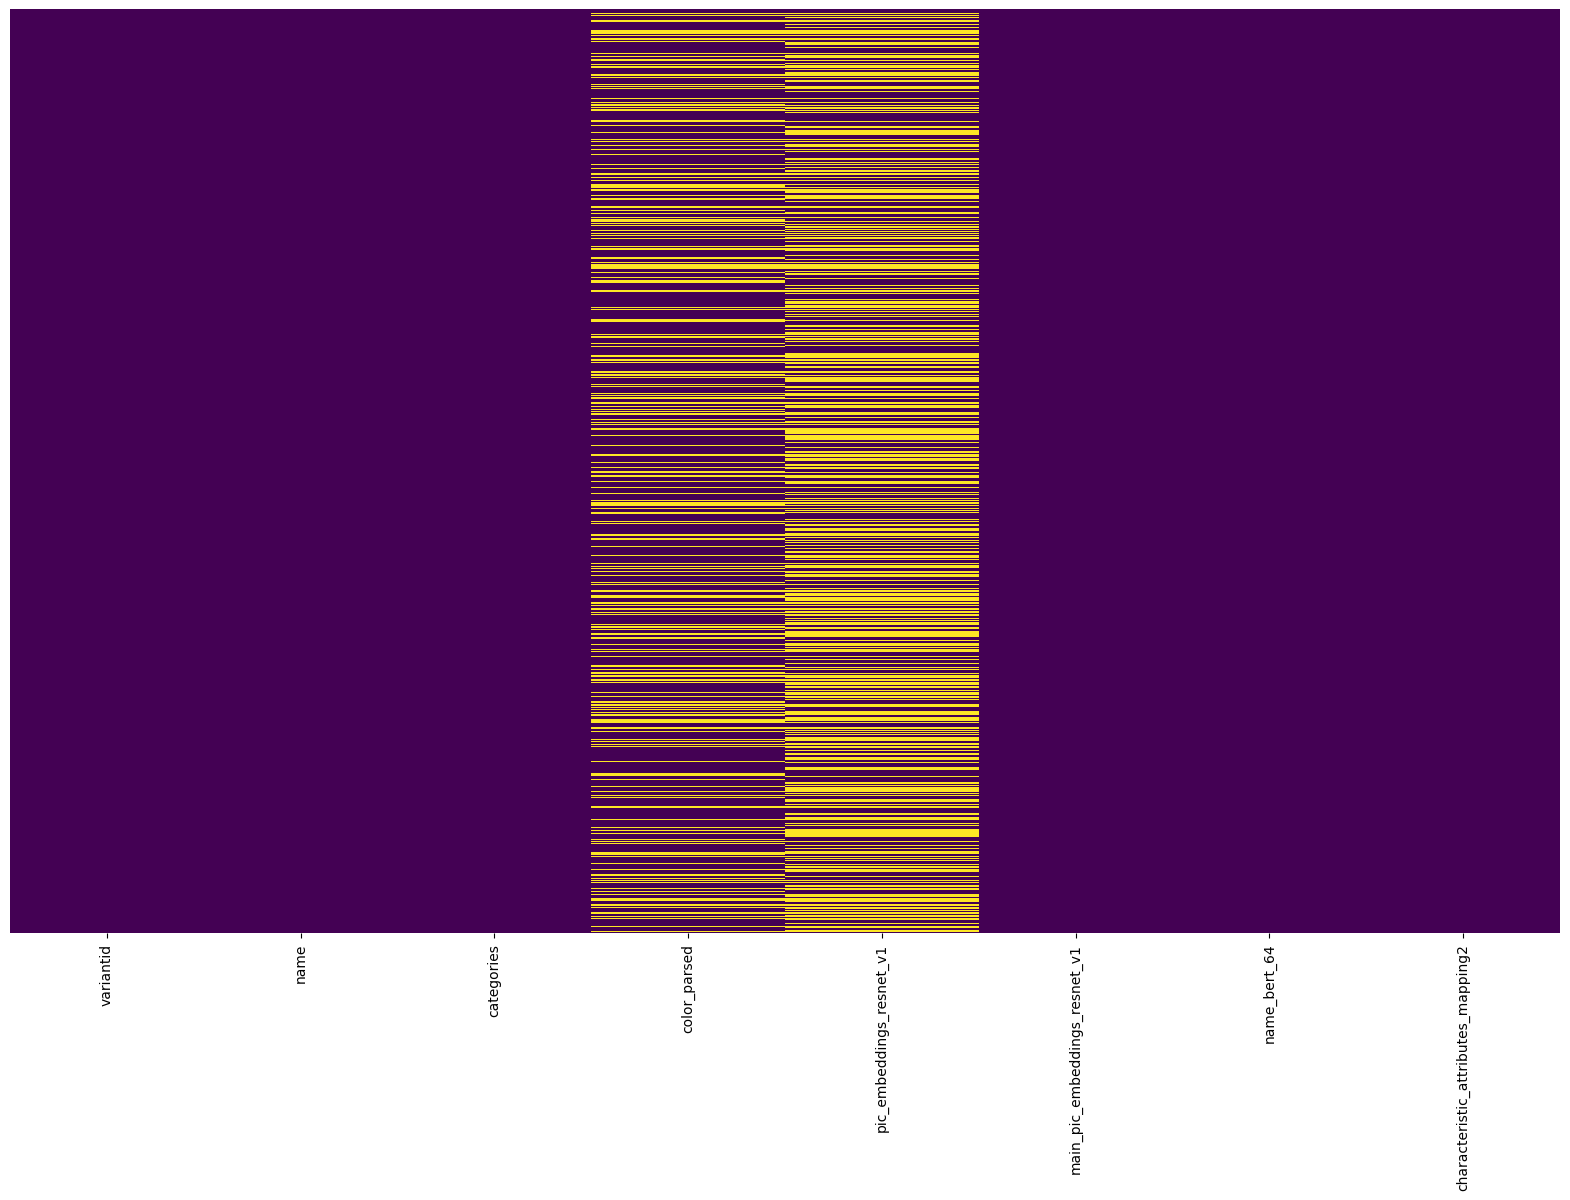

In [ ]:
fig, ax = plt.subplots(figsize=(20,12)) # Создаем область под график
sns_heatmap = sns.heatmap(df_test.isnull(), yticklabels=False, cbar=False, cmap='viridis') #Визуализируем пропуски
plt.show() # Отображаем график

###Детализация

In [ ]:
#name
i=7
print(df_test.name[i])
print('Тип данных:', type(df_test.name[i]))

Виниловый фотофон для предметной съемки стена-пол 50*100 см  коричневые доски
Тип данных: <class 'str'>


In [ ]:
#categories
i=7
print(df_test.categories[i])
print('Тип данных:', type(df_test.categories[i]))
#Переводим в словарь
categories_test_d = eval(df_test.categories[i])
print()
#Смотрим
for key, value in categories_test_d.items():
  print(f"{key}: {value}")

{"1": "EPG", "2": "Электроника", "3": "Аксессуары для фото и видеотехники", "4": "Фотофон"}
Тип данных: <class 'str'>

1: EPG
2: Электроника
3: Аксессуары для фото и видеотехники
4: Фотофон


In [ ]:
# Уникальные categories
categories_test = df_test.categories.unique()
categories_test.sort()
print('Всего категорий:', len(categories_test))
print(categories_test)

Всего категорий: 236
['{"1": "EPG", "2": "Электроника", "3": "CD проигрыватели и плееры", "4": "Оптический привод"}'
 '{"1": "EPG", "2": "Электроника", "3": "MP3-плееры", "4": "MP3 плеер"}'
 '{"1": "EPG", "2": "Электроника", "3": "MP3-плееры", "4": "Диктофон"}'
 '{"1": "EPG", "2": "Электроника", "3": "SIM-карты", "4": "Тариф для телефона"}'
 '{"1": "EPG", "2": "Электроника", "3": "Аксессуары для игровых приставок", "4": "Запчасти для игровых приставок и аксессуаров"}'
 '{"1": "EPG", "2": "Электроника", "3": "Аксессуары для игровых приставок", "4": "Игровая атрибутика"}'
 '{"1": "EPG", "2": "Электроника", "3": "Аксессуары для игровых приставок", "4": "Комплект игровых аксессуаров"}'
 '{"1": "EPG", "2": "Электроника", "3": "Аксессуары для игровых приставок", "4": "Накладка на контроллер"}'
 '{"1": "EPG", "2": "Электроника", "3": "Аксессуары для игровых приставок", "4": "Подставка для консоли"}'
 '{"1": "EPG", "2": "Электроника", "3": "Аксессуары для квадрокоптеров", "4": "Запчасти и комп

In [ ]:
#количество SKU в категориях
categories_test_val = pd.DataFrame(df_test['categories'].value_counts())
categories_test_val

categories
{"1": "EPG", "2": "Электроника", "3": "Расходни...        2866
{"1": "EPG", "2": "Электроника", "3": "Зарядные...        2666
{"1": "EPG", "2": "Электроника", "3": "Смарт-ча...        2630
{"1": "EPG", "2": "Электроника", "3": "Запчасти...        2382
{"1": "EPG", "2": "Электроника", "3": "Кабели и...        2005
...                                                        ...
{"1": "EPG", "2": "Электроника", "3": "ТВ-прист...           1
{"1": "EPG", "2": "Электроника", "3": "Аксессуа...           1
{"1": "EPG", "2": "Электроника", "3": "Видеокар...           1
{"1": "EPG", "2": "Электроника", "3": "Аксессуа...           1
{"1": "EPG", "2": "Электроника", "3": "Аксессуа...           1

[236 rows x 1 columns]

In [ ]:
df_random_category_test = df_test[df_test.categories == '{"1": "EPG", "2": "Электроника", "3": "Магнитола", "4": "Музыкальный центр"}']
df_random_category_test

variantid                                               name  \
2016    90924418  Telefunken Музыкальный центр Mini TF-PS2203 Black   
9520   449862603  Минисистема Digma MS-12 черный 160Вт/FM/USB/BT...   
11840  147940323        Музыкальный центр Mini Telefunken TF-PS2303   

                                              categories color_parsed  \
2016   {"1": "EPG", "2": "Электроника", "3": "Магнито...      [black]   
9520   {"1": "EPG", "2": "Электроника", "3": "Магнито...     [черный]   
11840  {"1": "EPG", "2": "Электроника", "3": "Магнито...     [черный]   

                                pic_embeddings_resnet_v1  \
2016   [[0.42160213, -0.25135127, 0.54759735, 0.65500...   
9520   [[-0.578392, -0.6233711, 1.2574191, 1.1466007,...   
11840  [[-0.1312604, 0.0282889, 0.1076326, 0.01193921...   

                           main_pic_embeddings_resnet_v1  \
2016   [[0.3675456, -0.30152872, 0.4174392, 0.7230401...   
9520   [[-0.5581606, -0.65394276, 1.2108932, 1.171549...   
11840  [[-0.019500218, -0.0060734004, -0.30830666, 0....   

                                            name_bert_64  \
2016   [-0.27433324, 0.6003876, 0.3480804, -0.4892024...   
9520   [-0.6072314, 0.2893073, 0.44810474, -0.4079852...   
11840  [-0.3170406, 0.66232634, 0.41942552, -0.446684...   

                      characteristic_attributes_mapping2  
2016   {"Тип":["Музыкальный центр"],"Вид музыкального...  
9520   {"Слот для карты памяти":["Да"],"Поддерживаемы...  
11840  {"Бренд":["Telefunken"],"Вес товара, г":["5200...

In [ ]:
#эмбендинги главного изображения
print(df_test.main_pic_embeddings_resnet_v1[0])
print(df_test.main_pic_embeddings_resnet_v1[0][0].shape)

[array([ 3.83107424e-01, -7.87667871e-01,  5.01827776e-01,  2.09007114e-01,
        -1.13766015e+00, -2.57687896e-01,  7.38754869e-01,  7.95346618e-01,
        -2.98218101e-01,  4.24641848e-01, -8.62099051e-01,  2.69418329e-01,
        -4.21551943e-01, -3.64148259e-01, -4.83366191e-01, -1.39786053e+00,
        -4.49158907e-01,  9.08652902e-01, -4.07682359e-02, -4.41769570e-01,
        -1.22073269e+00,  4.14606929e-01, -1.43891394e+00,  3.30252141e-01,
        -5.66333175e-01,  7.05745637e-01,  8.53058457e-01, -1.00870526e+00,
        -8.61750096e-02, -7.88374305e-01, -1.16311765e+00,  1.55019498e+00,
         7.59877086e-01, -2.69243300e-01,  7.94819117e-01,  1.29983902e+00,
        -2.25177407e-01,  1.48971629e+00, -3.70061934e-01, -6.00716949e-01,
         6.55798689e-02, -1.01537585e-01, -4.04206395e-01, -1.76997411e+00,
        -1.00108325e-01,  8.81828427e-01,  2.20752269e-01,  1.23659760e-01,
        -4.58977222e-01,  9.24035907e-01, -2.00883150e-01, -5.69410622e-04,
        -6.7

In [ ]:
#текстовые эмбендинги (наименование товара)
print(df_test.name_bert_64[0])
print(df_test.name_bert_64[0].shape)

[-0.5060825   0.5773388   0.59435517 -0.49582928  0.5487078   0.5381067
  0.12033223 -0.5241651   0.23317751 -0.5196649  -0.4403921   0.37189627
  0.7003845  -0.5096857   0.6402105   0.83008295  0.31477776  0.58593196
  0.48538408 -0.42456758  0.4713281  -0.5577031   0.15489759 -0.5941139
 -0.5936097  -0.43870553 -0.14107354 -0.47957492  0.5805049  -0.03031643
 -0.44097957  0.60626245 -0.5531169  -0.12242515  0.25293776  0.17102009
  0.6975018  -0.6104785   0.79069066  0.5859585   0.452074    0.78474635
  0.75477153 -0.44499332 -0.6933679  -0.327516   -0.6014938   0.09629604
 -0.24262887 -0.5723151  -0.45099244  0.3294349   0.19452716 -0.24104673
  0.66410756 -0.57459795  0.60047144  0.28255895 -0.35394976 -0.4875632
 -0.3054798   0.8222942   0.4989477  -0.42325228]
(64,)


In [ ]:
#атрибуты
i=2016
print(df_train.characteristic_attributes_mapping2[i])
print('Тип данных:', type(df_train.characteristic_attributes_mapping2[i]))
#Переводим в словарь
attribut_d = eval(df_train.characteristic_attributes_mapping2[i])
print()
#Смотрим
for key, value in attribut_d.items():
  print(f"{key}: {value}")

{"Акустическое оформление":["Открытое"],"Декоративное покрытие корпуса":["Пластик"],"Чувствительность, дБ":["80"],"Мин. частота, Гц":["100"],"Материал корпуса":["Пластик"],"Питание колонок":["Встроенный аккумулятор"],"Выходные интерфейсы":["USB Type-C"],"Входные интерфейсы":["6.3 мм","USB","microHDMI"],"Вид акустики":["Активная"],"Страна-изготовитель":["Китай"],"Гарантийный срок":["12  месяцев"],"Макс. частота, Гц":["18000"],"Расположение акустической системы":["Напольная"],"Мощность фронтальных колонок, Вт":["22"],"Максимальная мощность, Вт":["220"],"Сопротивление, Ом":["4"],"Назначение акустики":["Сабвуфер","Фронтальные колонки"],"Комплектация":["Инструкция - 1 шт; Кабель питания - 1 шт; пульт - 1 шт; Колонка - 1 шт"],"Конструктивные особенности":["Влагозащищенный корпус","Микрофон","Подсветка","Пульт ДУ","Сабвуфер в комплекте"],"Звуковая схема":["2.0"],"Тип":["Компьютерная акустика"],"Беспроводные интерфейсы":["Bluetooth"],"Материал диффузора":["Бумага"],"Размеры, мм":["230[230[450"

##df_train_pairs
Пары товаров. По target: 1 - аналоги, 0 - нет.

In [ ]:
df_train_pairs.head()

target  variantid1  variantid2
0     0.0    51197862    51198054
1     1.0    53062686   536165289
2     1.0    53602615   587809782
3     1.0    53888651    89598677
4     0.0    56930698   551526166

In [ ]:
df_train_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306540 entries, 0 to 306539
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   target      306540 non-null  float64
 1   variantid1  306540 non-null  int64  
 2   variantid2  306540 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 7.0 MB


##df_test_pairs_wo_target
Для финального тестирования модели и отправки решения на проверку в Ozon

In [ ]:
df_test_pairs_wo_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18084 entries, 0 to 18083
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   variantid1    18084 non-null  int64 
 1   variantid2    18084 non-null  int64 
 2   cat3_grouped  18084 non-null  object
dtypes: int64(2), object(1)
memory usage: 424.0+ KB


In [ ]:
df_test_pairs_wo_target.head()

variantid1  variantid2                             cat3_grouped
0    52076340   290590137                 Батарейки и аккумуляторы
1    64525522   204128919  Смартфоны, планшеты, мобильные телефоны
2    77243372   479860557                     Кабели и переходники
3    86065820   540678372                 Устройство ручного ввода
4    91566575   258840506  Смартфоны, планшеты, мобильные телефоны

##Анализ категорий

In [ ]:
#Добавляем новые столбцы в соответствие с категориями по разобраным данным из categories
df_train_cat = df_train.join(pd.json_normalize(df_train.categories.apply(json.loads)))
df_test_cat = df_test.join(pd.json_normalize(df_test.categories.apply(json.loads)))

In [ ]:
#Новые имена столбцам в соответствие с категориями
df_train_cat.rename(columns = {'1':'cat1', '2':'cat2', '3':'cat3', '4':'cat4'}, inplace = True )
df_test_cat.rename(columns = {'1':'cat1', '2':'cat2', '3':'cat3', '4':'cat4'}, inplace = True )

In [ ]:
df_train_cat.head(2)

variantid                                               name  \
0   51195767  Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...   
1   53565809  Магнитный кабель USB 2.0 A (m) - USB Type-C (m...   

                                          categories color_parsed  \
0  {"1": "EPG", "2": "Электроника", "3": "Сетевые...  [оранжевый]   
1  {"1": "EPG", "2": "Электроника", "3": "Кабели ...    [красный]   

                            pic_embeddings_resnet_v1  \
0                                               None   
1  [[0.26863545, -0.3130674, 0.29023397, 0.073978...   

                       main_pic_embeddings_resnet_v1  \
0  [[0.04603629, 0.18839523, -0.09973055, -0.6636...   
1  [[1.1471839, -0.665361, 0.7745614, 0.26716197,...   

                                        name_bert_64  \
0  [-0.47045058, 0.67237014, 0.48984158, -0.54485...   
1  [-0.6575592, 0.6522429, 0.5426037, -0.54347897...   

                  characteristic_attributes_mapping2 cat1         cat2  \
0  {"Номинальный ток, А":["10"],"Цвет товара":["о...  EPG  Электроника   
1  {"Конструктивные особенности":["Магнитная конс...  EPG  Электроника   

                                         cat3  \
0  Сетевые фильтры, разветвители и удлинители   
1                        Кабели и переходники   

                                       cat4  
0  Сетевой фильтр, удлинитель, разветвитель  
1                                    Кабель

In [ ]:
df_test_cat.head(2)

variantid                                               name  \
0   51201254  Колодка TDM Electric четырехместная без заземл...   
1   77151532    Клавиатура черная с черной рамкой для 25-011879   

                                          categories color_parsed  \
0  {"1": "EPG", "2": "Электроника", "3": "Сетевые...      [белый]   
1  {"1": "EPG", "2": "Электроника", "3": "Запчаст...     [черный]   

                            pic_embeddings_resnet_v1  \
0  [[0.34383398, -0.2962618, 0.07987049, -0.08257...   
1                                               None   

                       main_pic_embeddings_resnet_v1  \
0  [[0.38310742, -0.7876679, 0.5018278, 0.2090071...   
1  [[0.50964713, 0.7958329, -1.4113188, 0.1999381...   

                                        name_bert_64  \
0  [-0.5060825, 0.5773388, 0.59435517, -0.4958292...   
1  [-0.43467724, 0.6614495, 0.48050267, -0.588880...   

                  characteristic_attributes_mapping2 cat1         cat2  \
0  {"Страна-изготовитель":["Китай"],"Бренд":["TDM...  EPG  Электроника   
1  {"Страна-изготовитель":["Китай"],"Комплектация...  EPG  Электроника   

                                         cat3  \
0  Сетевые фильтры, разветвители и удлинители   
1                      Запчасти для ноутбуков   

                                       cat4  
0  Сетевой фильтр, удлинитель, разветвитель  
1                   Клавиатура для ноутбука

In [ ]:
#Описательные статистики
df_train_cat[['categories','cat1','cat2','cat3','cat4']].describe()

categories    cat1  \
count                                              457063  457063   
unique                                                358       1   
top     {"1": "EPG", "2": "Электроника", "3": "Смартфо...     EPG   
freq                                                51300  457063   

               cat2                                     cat3      cat4  
count        457063                                   457063    457063  
unique           13                                      127       357  
top     Электроника  Смартфоны, планшеты, мобильные телефоны  Смартфон  
freq         456843                                    59389     51300

In [ ]:
#Описательные статистики
df_test_cat[['categories','cat1','cat2','cat3','cat4']].describe()

categories   cat1         cat2  \
count                                               35730  35730        35730   
unique                                                236      1            1   
top     {"1": "EPG", "2": "Электроника", "3": "Расходн...    EPG  Электроника   
freq                                                 2866  35730        35730   

                          cat3      cat4  
count                    35730     35730  
unique                      74       236  
top     Запчасти для ноутбуков  Картридж  
freq                      4498      2866

In [ ]:
#Детализация по категориям
cat_cols = ['cat1','cat2','cat3','cat4']
for cat in cat_cols:
    print(cat,':', len(df_train_cat[cat].unique()))
    print(df_train_cat[cat].value_counts())
    print('\n')

cat1 : 1
EPG    457063
Name: cat1, dtype: int64


cat2 : 13
Электроника               456843
Хобби и творчество            52
Строительство и ремонт        52
Автотовары                    30
Детские товары                26
Канцелярские товары           18
Дом и сад                     18
Спорт и отдых                 12
Бытовая техника                5
Бытовая химия                  3
Галантерея и украшения         2
Товары для взрослых            1
Товары для животных            1
Name: cat2, dtype: int64


cat3 : 127
Смартфоны, планшеты, мобильные телефоны    59389
Компьютер                                  57572
Чехол                                      40775
Расходник для печати                       38878
Кабели и переходники                       26669
                                           ...  
Спортивные чехлы и сумки                       1
Охота и стрельба                               1
Солнечная, ветряная электростанция             1
Сувениры и подарки              

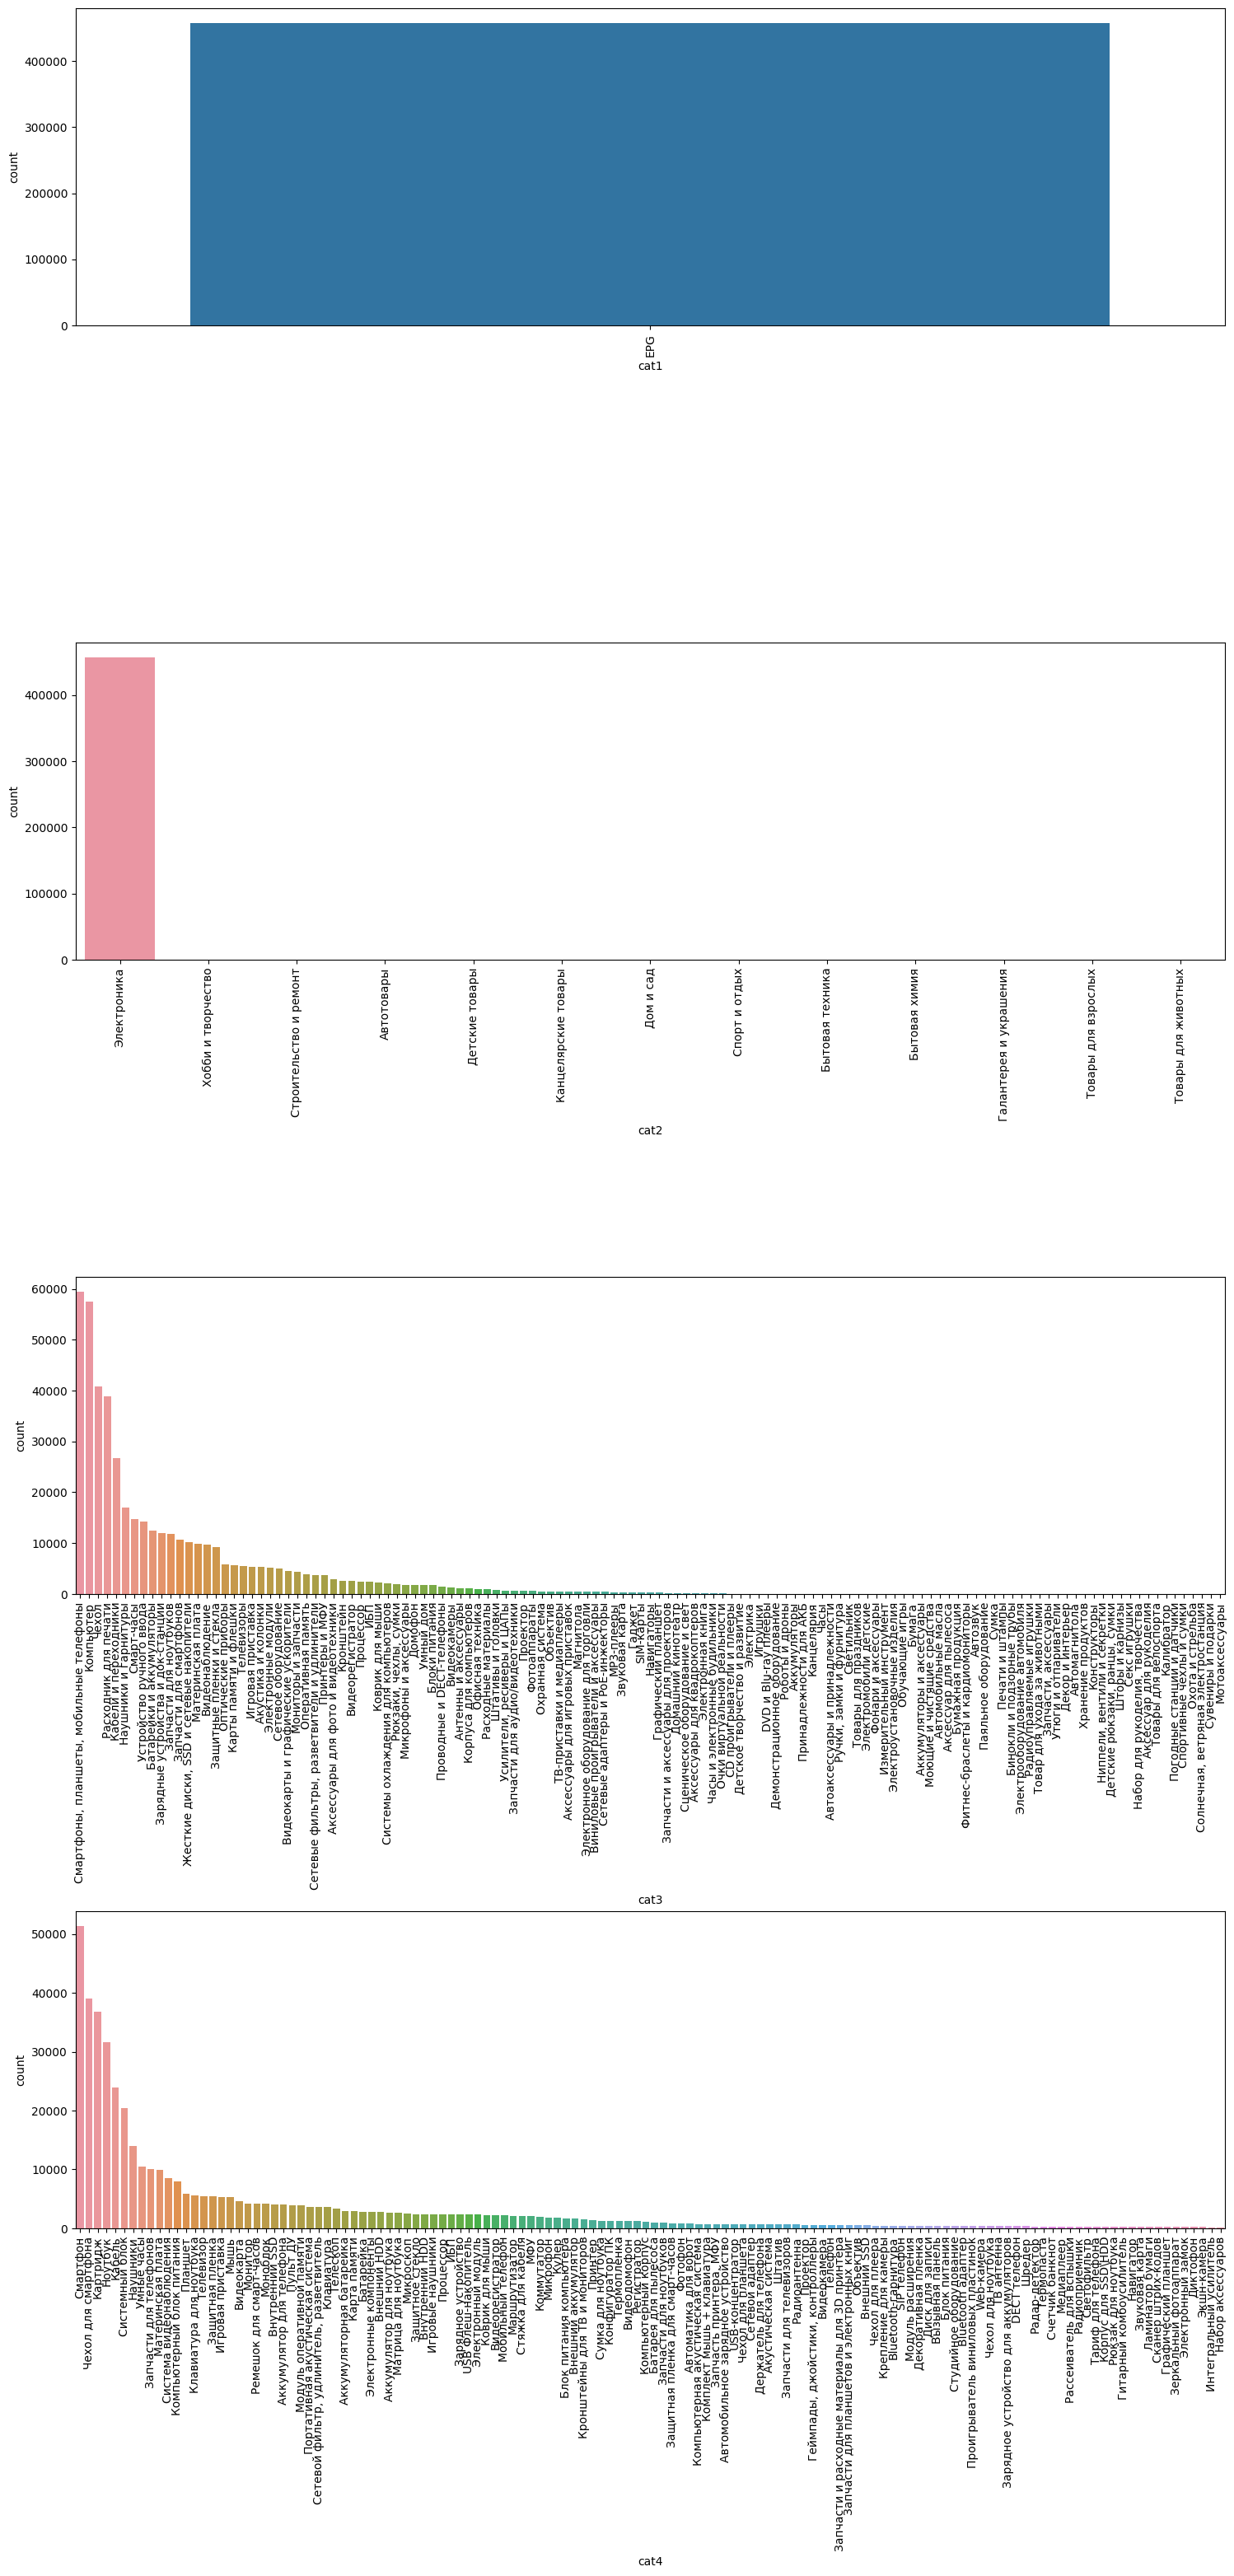

In [ ]:
#Визуализация распределений
fig, axes = plt.subplots(4, 1, figsize = (18,35))
plt.subplots_adjust(wspace = 0.2, hspace = 1)
axes = axes.flatten()
for i in range(len(cat_cols)):
    cntplt = sns.countplot(x = df_train_cat[cat_cols[i]], data = df_train_cat, order = df_train_cat[cat_cols[i]].value_counts()[:130].index, ax = axes[i])
    plt.setp(cntplt.get_xticklabels(), rotation = 90)

##Пары товаров с target

In [ ]:
df_train_pairs.head(2)

target  variantid1  variantid2
0     0.0    51197862    51198054
1     1.0    53062686   536165289

Количество:
 0.0    171527
1.0    135013
Name: target, dtype: int64

Процентное соотношение:
 0.0    55.95583
1.0    44.04417
Name: target, dtype: float64 %


<Axes: xlabel='target', ylabel='count'>

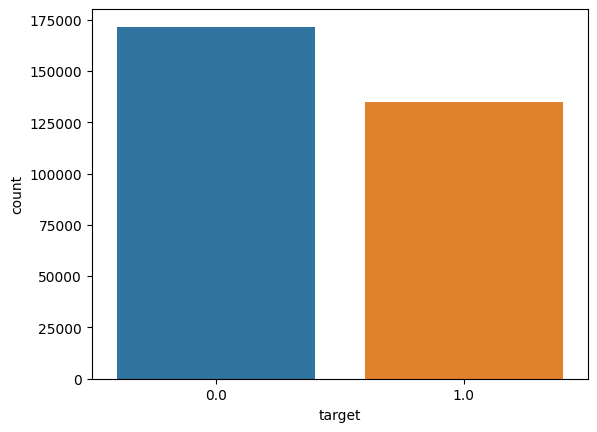

In [ ]:
print('Количество:\n', df_train_pairs.target.value_counts())
print('\nПроцентное соотношение:\n', df_train_pairs.target.value_counts(normalize=True) * 100, '%')
sns.countplot(x = df_train_pairs.target, data = df_train_pairs, order = df_train_pairs.target.value_counts().index)

44% - дубликаты, 56% - нет

#Предбработка данных

##Удаляем лишнее

In [ ]:
#Пропущенные значения
for col in df_train.columns:
    missing = np.mean(df_train[col].isnull())
    print('{} - {}%'.format(col, round(missing*100)))

variantid - 0%
name - 0%
categories - 0%
color_parsed - 17%
pic_embeddings_resnet_v1 - 34%
main_pic_embeddings_resnet_v1 - 0%
name_bert_64 - 0%
characteristic_attributes_mapping2 - 0%


Есть пропущенные значения в колонках color_parsed (17%) и pic_embeddings_resnet_v1 (34%). Колонку pic_embeddings_resnet_v1 удалим, т.к. пропущено более 30% значения. Колонку color_parsed также удалим, т.к. данная колонка дублирует данные в атрибутах. Колонку categories также удалим, т.к. в train она не нужна

In [ ]:
drop_cols = ['color_parsed','categories','pic_embeddings_resnet_v1']

In [ ]:
df_train_optimized = df_train.drop(drop_cols, axis=1)
df_train_optimized.head(3)

In [ ]:
df_test_optimized = df_test.drop(drop_cols, axis=1)
df_test_optimized.head(3)

##Обучающая и валидационная выборки

###Обучающая

In [ ]:
# Обработка в PyCharm (для экономии лимита колаба)
# Сводим данные по парам товаров для обучающей выборки
merged = df_train_pairs.merge(df_train.add_suffix('1'), on = 'variantid1', how = 'left')
train_val = merged.merge(df_train.add_suffix('2'), on = 'variantid2', how = 'left')
train_val.head(3)

In [ ]:
# Обработка в PyCharm (для экономии лимита колаба)
# Полный массив обучающей выборки по картинкам, shape (306540, 2, 128)
train_val_list_pic = []
for i in range(len(train_val)):
  train_val_list_pic.append(np.array([train_val.main_pic_embeddings_resnet_v11[i][0], train_val.main_pic_embeddings_resnet_v12[i][0]]))
train_val_arr_pic = np.array(train_val_list_pic)
# np.save('C:/Users/sokolov/MyData/Projects/hackathon_LCT/Output/train_val_arr_pic.npy', train_val_arr_pic)

In [ ]:
# Обработка в PyCharm (для экономии лимита колаба)
# Полный массив обучающей выборки по наименованиям, shape (306540, 2, 64)
train_val_list_name = []
for i in range(len(train_val)):
  train_val_list_name.append(np.array([train_val.name_bert_641[i], train_val.name_bert_642[i]]))
train_val_arr_name = np.array(train_val_list_name)
# np.save('C:/Users/sokolov/MyData/Projects/hackathon_LCT/Output/train_val_arr_name.npy', train_val_arr_name)

In [ ]:
# Обработка в PyCharm (для экономии лимита колаба)
# Полный массив по target для обучения, shape (306540, 2)
target_list = []
for i in range(len(train_val)):
  target_list.append(np.array([train_val.target[i]]))
target_list_arr = np.array(target_list)
y_train = utils.to_categorical(target_list_arr, 2)
# np.save('C:/Users/sokolov/MyData/Projects/hackathon_LCT/Output/y_train.npy', y_train)

###Сбор атрибутов и обработка Tokenizer'ом

In [ ]:
# Соединяем df_train и df_test чтобы получить полный словарь атрибутов
train_test_df = pd.concat([df_train, df_test])

In [ ]:
# Собираем все атрибуты в список для tokenizer'а
allText = []
allText_for_counts = [] # Для подсчёта кол-ва уникальных атрибутов
for i in range(len(train_test_df)):
    attributes_dict = eval(train_test_df.iloc[i, 7])
    attributes_list=[]
    for key, value in attributes_dict.items():
        key_data = re.sub(r"[^\w\s]", "", str(key))
        value_data = re.sub(r"[^\w\s]", "", str(value))
        attributes_list.append(str(key_data+value_data).replace(" ", ""))
        allText_for_counts.append(str(key_data+value_data).replace(" ", ""))
    allText.append(attributes_list)
len(allText) #492793

In [ ]:
# # Список уникальных атрибутов, с количеством повторений - порядка 20000 атрибутов повторяется 20 раз
word_counts = Counter(allText_for_counts)
for i in range(1, 21):
  unique_words = [word for word, count in word_counts.items() if count > i]
  print('больше {} раз - {}'.format(i, len(unique_words)))

In [ ]:
#################
# Преобразовываем текстовые данные в числовые/векторные для обучения нейросети
#################
#Обработка в PyCharm, у колаба не хватает ОЗУ
maxWordsCount = 20000 # определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')
# выше задаем параметры:
# (num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
# (lower=True) - приводим слова к нижнему регистру
# (split=' ') - разделяем слова по пробелу
# (char_level=False) - просим токенайзер не удалять однобуквенные слова

# "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
tokenizer.fit_on_texts(allText)
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра
print('Размер токенайзера', len(items))
print(items[:100]) # взглянем на содержимое словаря

In [ ]:
# Сохраняем файл tokenizer'а
with open('/content/drive/MyDrive/hackathon_LCT/Output/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Преобразование train_val по атрибутам в OHE и submission_test по атрибутам в OHE

In [ ]:
#Сводим данные по парам товаров для тестовой выборки для submission
merged = df_test_pairs_wo_target.merge(df_test.add_suffix('1'), on = 'variantid1', how = 'left')
submission_test = merged.merge(df_test.add_suffix('2'), on = 'variantid2', how = 'left')
# submission_test.head(3)

In [ ]:
# Загружаеем файл tokenizer'а
with open('/content/drive/MyDrive/hackathon_LCT/Output/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
# # Преобразуем train - сразу оба столбца товаров - железо не тянет такую большую обработку в OHE в дальнейшем
# # Поэтому далее(ниже) был принят другой способ - сначала по одному столбцу собраны идексы слов и преобразованя в OHE, потом по второму
# # Затем два OHE в несколько итераций соединены в один массив
# trainWordIndexes = []
# iter = 1
# max_len_list=0
# for i in range(len(train_val)):
#     attributes_list_pairs = []
#     for c in [9, 16]:
#         attributes_train_dict = eval(train_val.iloc[i, c])
#         attributes_list = []
#         for key, value in attributes_train_dict.items():
#             key_data = str(re.sub(r"[^\w\s]", "", str(key))).replace(" ", "")
#             value_data = str(re.sub(r"[^\w\s]", "", str(value))).replace(" ", "")
#             attributes_list.append(str(key_data+value_data).replace(" ", ""))
#         attributes_train_list_token = tokenizer.texts_to_sequences(attributes_list)
#         attributes_list_pairs.append(attributes_train_list_token)
#         if len(attributes_train_list_token) > max_len_list:
#              max_len_list = len(attributes_train_list_token)
#     trainWordIndexes.append(attributes_list_pairs)
#     print('Добавлена поз.', iter)
#     iter += 1
# print('Максимальная длина списка -', max_len_list)

In [ ]:
# Обработка в PyCharm, у колаба не хватает ОЗУ
# Преобразуем train_val и submission_test в списки индексов, сначала по одному столбцу, потом по другому
# Указываем train_val или submission_test
df_in = train_val
# df_in = submission_test

# Указываем номер столбца атрибутов: первый(9) или второй(16) столбец пары товаров
nom_col = 9
# nom_col = 16

wordIndexes = []
iter = 1
max_len_list=0
for i in range(len(df_in)):
    attributes_dict = eval(df_in.iloc[i, nom_col])
    attributes_list = []
    for key, value in attributes_dict.items():
        key_data = str(re.sub(r"[^\w\s]", "", str(key))).replace(" ", "")
        value_data = str(re.sub(r"[^\w\s]", "", str(value))).replace(" ", "")
        attributes_list.append(str(key_data+value_data).replace(" ", ""))
    attributes_list_token = tokenizer.texts_to_sequences(attributes_list)
    wordIndexes.append(attributes_list_token)
    if len(attributes_list_token) > max_len_list:
         max_len_list = len(attributes_list_token)
    print('Добавлена поз.', iter)
    iter += 1
print('Максимальная длина списка -', max_len_list)

In [ ]:
# По какой то причине texts_to_sequences каждый индекс записывает в отдельный список внутри списка атрибутов по каждой позиции
# Парсим эти отдельные списки и записываем в общий список атрибутов по каждой позиции
# Добиваем общие списки атрибутов по каждой позиции до единой длины max_len_list для train_val - 72, для submission_test - 64
wordIndexesList_1 =[]
for i in wordIndexes:
    indexStr_pairs=[]
    for c in i:
        indexStr_pairs.append(c[0])
        for r in range(max_len_list-len(indexStr_pairs)):
            indexStr_pairs.append(int(1))
    wordIndexesList_1.append(indexStr_pairs)

# #Этот вариант под вопросом
# wordIndexesList_1 =[]
# for i in wordIndexes_1:
#     indexStr_pairs=[]
#     for c in i:
#         indexStr = []
#         for j in c:
#             indexStr.append(int(j[0]))
#         for r in range(max_len_list-len(indexStr)):
#             indexStr.append(int(1))
#         indexStr_pairs.append(indexStr)
#     wordIndexesList_1.append(indexStr_pairs)

In [ ]:
# Переводим в массив trainWordIndexes_arr и submission_test_WordIndexes_arr. УСТАНОВИТЬ нужный уровень в имени файла _1 или _2:
# trainWordIndexes_arr_1
# trainWordIndexes_arr_2
# submission_test_WordIndexes_arr_1
# submission_test_WordIndexes_arr_2
trainWordIndexes_arr_2 = np.array(wordIndexesList_1)
np.save('/content/drive/MyDrive/hackathon_LCT/Output/trainWordIndexes_arr_2', trainWordIndexes_arr_2)

#Загрузка предобработанных массивов и токенайзера

In [ ]:
trainWordIndexes_arr_1 = np.load('/content/drive/MyDrive/hackathon_LCT/Output/trainWordIndexes_arr_1.npy')
trainWordIndexes_arr_2 = np.load('/content/drive/MyDrive/hackathon_LCT/Output/trainWordIndexes_arr_2.npy')
train_val_arr_pic = np.load('/content/drive/MyDrive/hackathon_LCT/Output/train_val_arr_pic.npy')
train_val_arr_name = np.load('/content/drive/MyDrive/hackathon_LCT/Output/train_val_arr_name.npy')
y_train = np.load('/content/drive/MyDrive/hackathon_LCT/Output/y_train.npy')
with open('/content/drive/MyDrive/hackathon_LCT/Output/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
voll_att_arr = np.empty((0, 2, 20000)) # Пустой массив для сбора массива на обучение

#Составная нейронка на два входа

In [ ]:
# input1 = Input((train_val_arr_pic.shape[1],train_val_arr_pic.shape[2]))
# input2 = Input((train_val_arr_name.shape[1],train_val_arr_name.shape[2]))
# # input3 = Input((xTrainRez01.shape[1],))
# x1= Conv1D(64, 3, padding='same', activation='relu')(input1)
# x1= Conv1D(32, 3, padding='same', activation='relu')(x1)
# x1= Conv1D(16, 3, padding='same', activation='relu')(x1)
# # x1= MaxPooling1D()

# x2= Conv1D(64, 3, padding='same', activation='relu')(input2)
# x2= Conv1D(32, 3, padding='same', activation='relu')(x2)
# x2= Conv1D(16, 3, padding='same', activation='relu')(x2)
# # x2= MaxPooling1D()

# x = concatenate([x1, x2])
# x = Conv1D(8, 3, padding='same', activation='relu')(x)
# x = Flatten()(x)
# output = Dense(2, activation='sigmoid')(x) # Финальный нейрон

# model= Model((input1, input2), output)
# print(model.summary())

#Составная нейронка на три входа. v1

In [ ]:
# input1 = Input((train_val_arr_pic.shape[1],train_val_arr_pic.shape[2]))
# input2 = Input((train_val_arr_name.shape[1],train_val_arr_name.shape[2]))
# input3 = Input((voll_att_arr.shape[1], voll_att_arr.shape[2]))
# x1= Conv1D(252, 3, padding='same', activation='relu')(input1)
# x1= Conv1D(126, 3, padding='same', activation='relu')(x1)
# x1= Conv1D(64, 3, padding='same', activation='relu')(x1)
# x1= Conv1D(32, 3, padding='same', activation='relu')(x1)
# x1= Conv1D(16, 3, padding='same', activation='relu')(x1)
# # x1= MaxPooling1D()

# x2= Conv1D(252, 3, padding='same', activation='relu')(input2)
# x2= Conv1D(126, 3, padding='same', activation='relu')(x2)
# x2= Conv1D(64, 3, padding='same', activation='relu')(x2)
# x2= Conv1D(32, 3, padding='same', activation='relu')(x2)
# x2= Conv1D(16, 3, padding='same', activation='relu')(x2)
# # x2= MaxPooling1D()

# x3= Dense(200, activation="relu")(input3)
# x3= Dropout(0.4)(x3) #Слой регуляризации Dropout
# x3= BatchNormalization()(x3) #Слой пакетной нормализации
# x3= Dense(100, activation='relu')(x3)
# x3= Dropout(0.4)(x3) #Слой регуляризации Dropout
# x3= BatchNormalization()(x3) #Слой пакетной нормализации
# x3= Dense(100, activation='relu')(x3)
# x3= Dropout(0.4)(x3) #Слой регуляризации Dropout
# x3= BatchNormalization()(x3) #Слой пакетной нормализации
# x3= Dense(16, activation="relu")(x3)

# x = concatenate([x1, x2, x3])
# x = Conv1D(8, 3, padding='same', activation='relu')(x)
# x = Flatten()(x)
# output = Dense(2, activation='sigmoid')(x) # Финальный нейрон

#Составная нейронка на три входа. v2

In [ ]:

input1 = Input((train_val_arr_pic.shape[1],train_val_arr_pic.shape[2]))
input2 = Input((train_val_arr_name.shape[1],train_val_arr_name.shape[2]))
input3 = Input((voll_att_arr.shape[1], voll_att_arr.shape[2]))
x1= Conv1D(64, 3, padding='same', activation='relu')(input1)
x1= Conv1D(32, 3, padding='same', activation='relu')(x1)
x1= Conv1D(16, 3, padding='same', activation='relu')(x1)
# x1= MaxPooling1D()

x2= Conv1D(64, 3, padding='same', activation='relu')(input2)
x2= Conv1D(32, 3, padding='same', activation='relu')(x2)
x2= Conv1D(16, 3, padding='same', activation='relu')(x2)
# x2= MaxPooling1D()

x3= Dense(200, activation="relu")(input3)
x3= Dropout(0.25)(x3) #Слой регуляризации Dropout
x3= BatchNormalization()(x3) #Слой пакетной нормализации
x3= Dense(16, activation="relu")(x3)

x = concatenate([x1, x2, x3])
x = Conv1D(8, 3, padding='same', activation='relu')(x)
x = Flatten()(x)
output = Dense(2, activation='sigmoid')(x) # Финальный нейрон

model= Model((input1, input2, input3), output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2, 20000)]   0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2, 128)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2, 64)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 2, 200)       4000200     ['input_3[0][0]']                
                                                                                              

#Составная нейронка U-net 1

In [ ]:
# input1 = Input((train_val_arr_pic.shape[1],train_val_arr_pic.shape[2]))
# input2 = Input((train_val_arr_name.shape[1],train_val_arr_name.shape[2]))
# # input3 = Input((xTrainRez01.shape[1],))

# activation='relu'

# ################################# input1
# # Block 1
# x = Conv1D(64, 3, padding='same', name='block1_conv1')(input1)           # Добавляем Conv1D-слой с 64-нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = Conv1D(64, 3, padding='same', name='block1_conv2')(x)                   # Добавляем Conv1D-слой с 64-нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# block_1_out = Activation(activation)(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

# x11 = Conv1D(32, 3, padding='same', name='block1_conv3')(block_1_out)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# x11 = BatchNormalization()(x11)                                             # Добавляем слой BatchNormalization
# x11 = Activation(activation)(x11)

# x12 = Conv1D(16, 3, padding='same', name='block1_conv4')(block_1_out)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# x12 = BatchNormalization()(x12)                                             # Добавляем слой BatchNormalization
# x12 = Activation(activation)(x12)

# x13 = Conv1D(8, 3, padding='same', name='block1_conv5')(block_1_out)        # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# x13 = BatchNormalization()(x13)                                             # Добавляем слой BatchNormalization
# x13 = Activation(activation)(x13)

# concat_x1 = concatenate([x11, x12, x13])                                    # Конкатенируем 3 слоя

# block_1_out_mask = Conv1D(64, 1, padding='same')(concat_x1)                 # Добавляем concat_x к текущему слою и запоминаем в переменную block_1_out_mask

# x = MaxPooling1D()(block_1_out)                                             # Добавляем слой MaxPooling2D

# # Block 2
# x = Conv1D(128, 3, padding='same', name='block2_conv1')(x)                  # Добавляем Conv1D-слой с 128-нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = Conv1D(128, 3, padding='same', name='block2_conv2')(x)                  # Добавляем Conv1D-слой с 128-нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# block_2_out = Activation(activation)(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

# x21 = Conv1D(32, 3, padding='same', name='block2_conv3')(block_2_out)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# x21 = BatchNormalization()(x21)                                             # Добавляем слой BatchNormalization
# x21 = Activation(activation)(x21)

# x22 = Conv1D(16, 3, padding='same', name='block2_conv4')(block_2_out)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# x22 = BatchNormalization()(x22)                                             # Добавляем слой BatchNormalization
# x22 = Activation(activation)(x22)

# x23 = Conv1D(8, 3, padding='same', name='block2_conv5')(block_2_out)        # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# x23 = BatchNormalization()(x23)                                             # Добавляем слой BatchNormalization
# x23 = Activation(activation)(x23)

# concat_x2 = concatenate([x21, x22, x23])                                    # Конкатенируем 3 слоя

# block_2_out_mask = Conv1D(128, 1, padding='same')(concat_x2)                # Добавляем concat_x к текущему слою и запоминаем в переменную block_2_out_mask

# x = MaxPooling1D()(block_2_out)                                             # Добавляем слой MaxPooling1D

# # Block 3
# x = Conv1D(256, 3, padding='same', name='block3_conv1')(x)                  # Добавляем Conv1D-слой с 256-нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = Conv1D(256, 3, padding='same', name='block3_conv2')(x)                  # Добавляем Conv1D-слой с 256-нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# block_3_out = Activation(activation)(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

# x31 = Conv1D(32, 3, padding='same', name='block3_conv3')(block_3_out)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# x31 = BatchNormalization()(x31)                                             # Добавляем слой BatchNormalization
# x31 = Activation(activation)(x31)

# x32 = Conv1D(16, 3, padding='same', name='block3_conv4')(block_3_out)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# x32 = BatchNormalization()(x32)                                             # Добавляем слой BatchNormalization
# x32 = Activation(activation)(x32)

# x33 = Conv1D(8, 3, padding='same', name='block3_conv5')(block_3_out)        # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# x33 = BatchNormalization()(x33)                                             # Добавляем слой BatchNormalization
# x33 = Activation(activation)(x33)

# concat_x3 = concatenate([x31, x32, x33])                                    # Конкатенируем 3 слоя

# block_3_out_mask = Conv1D(256, 1, padding='same')(concat_x3)                # Добавляем concat_x к текущему слою и запоминаем в переменную block_3_out_mask

# x = MaxPooling1D()(block_3_out)                                             # Добавляем слой MaxPooling1D

#   # Block 4
# x = Conv1D(512, 3, padding='same', name='block4_conv1')(x)                  # Добавляем Conv1D-слой с 512-нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = Conv1D(512, 3, padding='same', name='block4_conv2')(x)                  # Добавляем Conv1D-слой с 256-нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# block_4_out = Activation(activation)(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out

# x41 = Conv1D(32, 3, padding='same', name='block4_conv3')(block_4_out)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# x41 = BatchNormalization()(x41)                                             # Добавляем слой BatchNormalization
# x41 = Activation(activation)(x41)

# x42 = Conv1D(16, 3, padding='same', name='block4_conv4')(block_4_out)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# x42 = BatchNormalization()(x42)                                             # Добавляем слой BatchNormalization
# x42 = Activation(activation)(x42)

# x43 = Conv1D(8, 3, padding='same', name='block4_conv5')(block_4_out)        # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# x43 = BatchNormalization()(x43)                                             # Добавляем слой BatchNormalization
# x43 = Activation(activation)(x43)

# concat_x4 = concatenate([x41, x42, x43])                                    # Конкатенируем 3 слоя

# block_4_out_mask = Conv1D(512, 1, padding='same')(concat_x4)                # Добавляем concat_x к текущему слою и запоминаем в переменную block_4_out_mask

# x = MaxPooling1D()(block_4_out)                                             # Добавляем слой MaxPooling2D

# # Block 5
# x = Conv1D(512, 3, padding='same', name='block5_conv1')(x)                  # Добавляем Conv1D-слой с 512-нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = Conv1D(512, 3, padding='same', name='block5_conv2')(x)                  # Добавляем Conv1D-слой с 512-нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = Conv1D(512, 3, padding='same', name='block5_conv3')(x)                  # Добавляем Conv1D-слой с 512-нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# # UP 1
# x = Conv1DTranspose(512, kernel_size=3, strides=2, padding='same')(x)       # Добавляем слой Conv1DTranspose с 512 нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = concatenate([x, block_4_out, block_4_out_mask])                         # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
# x = Conv1D(512, 3, padding='same')(x)                                       # Добавляем слой Conv1D с 512 нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = Conv1D(512, 3, padding='same')(x)                                       # Добавляем слой Conv1D с 512 нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# # UP 2
# x = Conv1DTranspose(256, kernel_size=3, strides=2, padding='same')(x)       # Добавляем слой Conv1DTranspose с 256 нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = concatenate([x, block_3_out, block_3_out_mask])                         # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
# x = Conv1D(256, 3, padding='same')(x)                                       # Добавляем слой Conv1D с 256 нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = Conv1D(256, 3, padding='same')(x)                                       # Добавляем слой Conv1D с 256 нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# # UP 3
# x = Conv1DTranspose(128, kernel_size=3, strides=2, padding='same')(x)       # Добавляем слой Conv1DTranspose с 128 нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = concatenate([x, block_2_out, block_2_out_mask])                         # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
# x = Conv1D(128, 3, padding='same')(x)                                       # Добавляем слой Conv1D с 128 нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = Conv1D(128, 3, padding='same')(x)                                       # Добавляем слой Conv1D с 128 нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# # UP 4
# x = Conv1DTranspose(64, kernel_size=3, strides=2, padding='same')(x)        # Добавляем слой Conv1DTranspose с 64 нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = concatenate([x, block_1_out, block_1_out_mask])                         # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
# x = Conv1D(64, 3, padding='same')(x)                                        # Добавляем слой Conv1D с 128 нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# x = Conv1D(64, 3, padding='same')(x)                                        # Добавляем слой Conv1D с 128 нейронами
# x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
# x = Activation(activation)(x)                                               # Добавляем слой Activation

# ################################### input2
# # Block 1
# y = Conv1D(64, 3, padding='same', name='block1_conv1')(input2)           # Добавляем Conv1D-слой с 64-нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = Conv1D(64, 3, padding='same', name='block1_conv2')(y)                   # Добавляем Conv1D-слой с 64-нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# block_1_out_y = Activation(activation)(y)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

# y11 = Conv1D(32, 3, padding='same', name='block1_conv3')(block_1_out_y)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# y11 = BatchNormalization()(y11)                                             # Добавляем слой BatchNormalization
# y11 = Activation(activation)(y11)

# y12 = Conv1D(16, 3, padding='same', name='block1_conv4')(block_1_out_y)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# y12 = BatchNormalization()(y12)                                             # Добавляем слой BatchNormalization
# y12 = Activation(activation)(y12)

# y13 = Conv1D(8, 3, padding='same', name='block1_conv5')(block_1_out_y)        # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# y13 = BatchNormalization()(y13)                                             # Добавляем слой BatchNormalization
# y13 = Activation(activation)(y13)

# concat_y1 = concatenate([y11, y12, y13])                                    # Конкатенируем 3 слоя

# block_1_out_mask_y = Conv1D(64, 1, padding='same')(concat_y1)                 # Добавляем concat_x к текущему слою и запоминаем в переменную block_1_out_mask

# y = MaxPooling1D()(block_1_out_y)                                             # Добавляем слой MaxPooling2D

# # Block 2
# y = Conv1D(128, 3, padding='same', name='block2_conv1_y')(y)                  # Добавляем Conv1D-слой с 128-нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = Conv1D(128, 3, padding='same', name='block2_conv2_y')(y)                  # Добавляем Conv1D-слой с 128-нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# block_2_out_y = Activation(activation)(y)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

# y21 = Conv1D(32, 3, padding='same', name='block2_conv3_y')(block_2_out_y)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# y21 = BatchNormalization()(y21)                                             # Добавляем слой BatchNormalization
# y21 = Activation(activation)(y21)

# y22 = Conv1D(16, 3, padding='same', name='block2_conv4_y')(block_2_out_y)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# y22 = BatchNormalization()(y22)                                             # Добавляем слой BatchNormalization
# y22 = Activation(activation)(y22)

# y23 = Conv1D(8, 3, padding='same', name='block2_conv5_y')(block_2_out_y)        # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# y23 = BatchNormalization()(y23)                                             # Добавляем слой BatchNormalization
# y23 = Activation(activation)(y23)

# concat_y2 = concatenate([y21, y22, y23])                                    # Конкатенируем 3 слоя

# block_2_out_mask_y = Conv1D(128, 1, padding='same')(concat_y2)                # Добавляем concat_x к текущему слою и запоминаем в переменную block_2_out_mask

# y = MaxPooling1D()(block_2_out_y)                                             # Добавляем слой MaxPooling1D

# # Block 3
# y = Conv1D(256, 3, padding='same', name='block3_conv1_y')(y)                  # Добавляем Conv1D-слой с 256-нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = Conv1D(256, 3, padding='same', name='block3_conv2_y')(y)                  # Добавляем Conv1D-слой с 256-нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# block_3_out_y = Activation(activation)(y)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

# y31 = Conv1D(32, 3, padding='same', name='block3_conv3_y')(block_3_out_y)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# y31 = BatchNormalization()(y31)                                             # Добавляем слой BatchNormalization
# y31 = Activation(activation)(y31)

# y32 = Conv1D(16, 3, padding='same', name='block3_conv4_y')(block_3_out_y)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# y32 = BatchNormalization()(y32)                                             # Добавляем слой BatchNormalization
# y32 = Activation(activation)(y32)

# y33 = Conv1D(8, 3, padding='same', name='block3_conv5_y')(block_3_out_y)        # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# y33 = BatchNormalization()(y33)                                             # Добавляем слой BatchNormalization
# y33 = Activation(activation)(y33)

# concat_y3 = concatenate([y31, y32, y33])                                    # Конкатенируем 3 слоя

# block_3_out_mask_y = Conv1D(256, 1, padding='same')(concat_y3)                # Добавляем concat_x к текущему слою и запоминаем в переменную block_3_out_mask

# y = MaxPooling1D()(block_3_out_y)                                             # Добавляем слой MaxPooling1D

#   # Block 4
# y = Conv1D(512, 3, padding='same', name='block4_conv1_y')(y)                  # Добавляем Conv1D-слой с 512-нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = Conv1D(512, 3, padding='same', name='block4_conv2_y')(y)                  # Добавляем Conv1D-слой с 256-нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# block_4_out_y = Activation(activation)(y)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out

# y41 = Conv1D(32, 3, padding='same', name='block4_conv3_y')(block_4_out_y)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# y41 = BatchNormalization()(y41)                                             # Добавляем слой BatchNormalization
# y41 = Activation(activation)(y41)

# y42 = Conv1D(16, 3, padding='same', name='block4_conv4_y')(block_4_out_y)       # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# y42 = BatchNormalization()(y42)                                             # Добавляем слой BatchNormalization
# y42 = Activation(activation)(y42)

# y43 = Conv1D(8, 3, padding='same', name='block4_conv5_y')(block_4_out_y)        # Добавляем Conv1D-слой в блок из 3х слоёв к пробросу
# y43 = BatchNormalization()(y43)                                             # Добавляем слой BatchNormalization
# y43 = Activation(activation)(y43)

# concat_y4 = concatenate([y41, y42, y43])                                    # Конкатенируем 3 слоя

# block_4_out_mask_y = Conv1D(512, 1, padding='same')(concat_y4)                # Добавляем concat_x к текущему слою и запоминаем в переменную block_4_out_mask

# y = MaxPooling1D()(block_4_out_y)                                             # Добавляем слой MaxPooling2D

# # Block 5
# y = Conv1D(512, 3, padding='same', name='block5_conv1_y')(y)                  # Добавляем Conv1D-слой с 512-нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = Conv1D(512, 3, padding='same', name='block5_conv2_y')(y)                  # Добавляем Conv1D-слой с 512-нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = Conv1D(512, 3, padding='same', name='block5_conv3_y')(y)                  # Добавляем Conv1D-слой с 512-нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# # UP 1
# y = Conv1DTranspose(512, kernel_size=3, strides=2, padding='same')(y)       # Добавляем слой Conv1DTranspose с 512 нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = concatenate([y, block_4_out_y, block_4_out_mask_y])                         # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
# y = Conv1D(512, 3, padding='same')(y)                                       # Добавляем слой Conv1D с 512 нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = Conv1D(512, 3, padding='same')(y)                                       # Добавляем слой Conv1D с 512 нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# # UP 2
# y = Conv1DTranspose(256, kernel_size=3, strides=2, padding='same')(y)       # Добавляем слой Conv1DTranspose с 256 нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = concatenate([y, block_3_out_y, block_3_out_mask_y])                         # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
# y = Conv1D(256, 3, padding='same')(y)                                       # Добавляем слой Conv1D с 256 нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = Conv1D(256, 3, padding='same')(y)                                       # Добавляем слой Conv1D с 256 нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# # UP 3
# y = Conv1DTranspose(128, kernel_size=3, strides=2, padding='same')(y)       # Добавляем слой Conv1DTranspose с 128 нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = concatenate([y, block_2_out_y, block_2_out_mask_y])                         # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
# y = Conv1D(128, 3, padding='same')(y)                                       # Добавляем слой Conv1D с 128 нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = Conv1D(128, 3, padding='same')(y)                                       # Добавляем слой Conv1D с 128 нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# # UP 4
# y = Conv1DTranspose(64, kernel_size=3, strides=2, padding='same')(y)        # Добавляем слой Conv1DTranspose с 64 нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = concatenate([y, block_1_out_y, block_1_out_mask_y])                         # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
# y = Conv1D(64, 3, padding='same')(y)                                        # Добавляем слой Conv1D с 128 нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation

# y = Conv1D(64, 3, padding='same')(y)                                        # Добавляем слой Conv1D с 128 нейронами
# y = BatchNormalization()(y)                                                 # Добавляем слой BatchNormalization
# y = Activation(activation)(y)                                               # Добавляем слой Activation


# xy = concatenate([x, y])

# xy = Conv1D(32, 3, padding='same', activation='relu')(xy)
# xy = Flatten()(xy)
# output = Dense(2, activation='sigmoid')(xy) # Финальный нейрон

# model= Model((input1, input2), output)
# # print(model.summary())

#Составная нейронка U-net 2

In [ ]:
# # train_val_arr_pic = np.reshape(train_val_arr_pic, (train_val_arr_pic.shape[0], 1, train_val_arr_pic.shape[1]*train_val_arr_pic.shape[2]))
# # train_val_arr_name = np.reshape(train_val_arr_name, (train_val_arr_name.shape[0], 1, train_val_arr_name.shape[1]*train_val_arr_name.shape[2]))

# input1 = Input((train_val_arr_pic.shape[1],train_val_arr_pic.shape[2]))
# input2 = Input((train_val_arr_name.shape[1],train_val_arr_name.shape[2]))
# k = 1

# ################################# input1
# # Блок 1
# x = Conv1D(64 * k , 3, padding='same')(input1)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = Conv1D(64 * k, 3, padding='same')(x)
# x = BatchNormalization()(x)
# block_1_out = Activation('relu')(x)

# # Блок 2
# x = MaxPooling1D()(block_1_out)
# x = Conv1D(128 * k, 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = Conv1D(128 * k , 3, padding='same')(x)
# x = BatchNormalization()(x)
# block_2_out = Activation('relu')(x)
# block_2_out = Reshape((2, int(block_2_out.shape[2]/2)))(block_2_out)#########

# # Блок 3
# x = MaxPooling1D()(block_2_out)
# x = Conv1D(256 * k, 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = Conv1D(256 * k , 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = Conv1D(256 * k , 3, padding='same')(x)
# x = BatchNormalization()(x)
# block_3_out = Activation('relu')(x)
# block_3_out = Reshape((2, int(block_3_out.shape[2]/2)))(block_3_out)

# # Блок 4
# x = MaxPooling1D()(block_3_out)
# x = Conv1D(512 * k, 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = Conv1D(512 * k , 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = Conv1D(512 * k , 3, padding='same')(x)
# x = BatchNormalization()(x)
# block_4_out = Activation('relu')(x)
# x = block_4_out

# # UP 2
# x = Conv1DTranspose(256 * k, kernel_size=3, strides=2, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = concatenate([x, block_3_out])
# x = Conv1D(256 * k , 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = Conv1D(256 * k , 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# # UP 3
# x = Conv1DTranspose(128 * k, kernel_size=3, strides=2, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = Reshape((2, int(x.shape[2]*2)))(x) ####################################
# x = concatenate([x, block_2_out])
# x = Conv1D(128 * k , 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = Conv1D(128 * k , 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# # UP 4
# x = Conv1DTranspose(64 * k, kernel_size=3, strides=2, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = Reshape((2, int(x.shape[2]*2)))(x) ####################################
# x = concatenate([x, block_1_out])
# x = Conv1D(64 * k , 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# x = Conv1D(64 * k , 3, padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# ################################# input2
# # Блок 1
# y = Conv1D(64 * k , 3, padding='same')(input1)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# y = Conv1D(64 * k, 3, padding='same')(y)
# y = BatchNormalization()(y)
# block_1_out_y = Activation('relu')(y)

# # Блок 2
# y = MaxPooling1D()(block_1_out_y)
# y = Conv1D(128 * k, 3, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# y = Conv1D(128 * k , 3, padding='same')(y)
# y = BatchNormalization()(y)
# block_2_out_y = Activation('relu')(y)
# block_2_out_y = Reshape((2, int(block_2_out_y.shape[2]/2)))(block_2_out_y)#########

# # Блок 3
# y = MaxPooling1D()(block_2_out_y)
# y = Conv1D(256 * k, 3, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# y = Conv1D(256 * k , 3, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# y = Conv1D(256 * k , 3, padding='same')(y)
# y = BatchNormalization()(y)
# block_3_out_y = Activation('relu')(y)
# block_3_out_y = Reshape((2, int(block_3_out_y.shape[2]/2)))(block_3_out_y)#########

# # Блок 4
# y = MaxPooling1D()(block_3_out_y)
# y = Conv1D(512 * k, 3, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# y = Conv1D(512 * k , 3, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# y = Conv1D(512 * k , 3, padding='same')(y)
# y = BatchNormalization()(y)
# block_4_out_y = Activation('relu')(y)
# y = block_4_out_y

# # UP 2
# y = Conv1DTranspose(256 * k, kernel_size=3, strides=2, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# y = concatenate([y, block_3_out_y])
# y = Conv1D(256 * k , 3, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# y = Conv1D(256 * k , 3, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# # UP 3
# y = Conv1DTranspose(128 * k, kernel_size=3, strides=2, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# y = Reshape((2, int(y.shape[2]*2)))(y) ####################################
# y = concatenate([y, block_2_out_y])
# y = Conv1D(128 * k , 3, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# y = Conv1D(128 * k , 3, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# # UP 4
# y = Conv1DTranspose(64 * k, kernel_size=3, strides=2, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)
# y = Reshape((2, int(y.shape[2]*2)))(y) ####################################

# y = concatenate([y, block_1_out_y])
# y = Conv1D(64 * k , 3, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# y = Conv1D(64 * k , 3, padding='same')(y)
# y = BatchNormalization()(y)
# y = Activation('relu')(y)

# xy = concatenate([x, y])

# xy = Conv1D(32, 3, padding='same', activation='relu')(xy)
# xy = Flatten()(xy)
# output = Dense(2, activation='sigmoid')(xy) # Финальный нейрон

# model= Model((input1, input2), output)

#Callback

In [ ]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # Атрибут best_weights для хранения весов, при которых достигнуто минимальное значение лосс-функции
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # Количество эпох, в течение которых значение лосс-фунции больше минимального
        self.wait = 0
        # Эпоха, на которой останавливается обучение
        self.stopped_epoch = 0
        # Лучшее текущее минимальное значение лосс-функции равно бесконечности
        self.best = np.Inf
        self.lr = round(float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)), 3)

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_loss')
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Запись лучших весов (если текущие результаты лучше, т.е. меньше)
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
        else:
            self.wait += 1
            if self.wait >= self.patience-20:
              if self.lr == 0.001:
                tf.keras.backend.set_value(self.model.optimizer.lr, round(self.lr/10, 4))
                self.lr = round(float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)), 4)
                print("\nЭпоха %05d: Learning rate is %6.4f." % (epoch, self.lr))
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Восстановление весов моделей с конца лучшей эпохи.")
                self.model.set_weights(self.best_weights)


    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Эпоха %05d: ранняя остановка" % (self.stopped_epoch + 1))
        print("Эпоха с лучшим val_loss:  %05d" % (self.best_epoch + 1))
        print("val_loss:", self.best)

#Обучение

In [ ]:
# Функция записи результатов обучения в txt-файл
def training_report(model_name, val_accuracy_best, val_loss_min, val_epoches, i):
  training_report = []
  training_report.append('Точность лучшая: '+ str(round(val_accuracy_best, 4)))
  training_report.append('Ошибка наименьшая: '+ str(round(val_loss_min, 4)))
  training_report.append('Эпох пройдено: '+ str(val_epoches))
  training_report.append('Итераций пройдено: '+ str(i+1))

  # Открываем файл для записи
  with open('/content/drive/MyDrive/hackathon_LCT/weights/'+ model_name +'_report.txt', 'w') as f:
      # Записываем каждый элемент списка в файл
      for item in training_report:
          f.write("%s\n" % item)

# Функция записи summary модели в txt-файл
def model_summary_save(model, model_name):
  with open('/content/drive/MyDrive/hackathon_LCT/weights/' + model_name + '_summary.txt', 'w') as f:
      model.summary(print_fn=lambda x: f.write(x + '\n'))

In [ ]:
# Для обработки всего объёма OHE-массивов из атрибутов ОЗУ Colab'а не хватает, поэтому подаём на обучение частями в размере voll_att_shape

# Функция подачи на обучение OHE-массивов из атрибутов
def getAttribute01(trainWordIndexes_arr_1, trainWordIndexes_arr_2, voll_att_shape, voll_att_shape_out):
  voll_att_arr = np.empty((0, 2, 20000)) # Пустой массив для сбора массива на обучение
  for i in range(voll_att_shape_out, voll_att_shape_out + voll_att_shape):
      arr_concat = np.concatenate(([trainWordIndexes_arr_1[i]], [trainWordIndexes_arr_2[i]]), axis=0)
      arr_token = tokenizer.sequences_to_matrix(arr_concat.tolist())
      voll_att_arr = np.concatenate((voll_att_arr, arr_token[np.newaxis, :, :]), axis=0)
  return voll_att_arr

# Входные параметры функции обработки массивов атрибутов и обучения
# Номер стартовой итерации при дообучении модели. Если запуск первичныйй, то поставить 0
val_prev_iter = 0  # Количество пройденных итераций по обучающим массивам атрибутов на предыдущем обучении
val_accuracy_best = 0  # Точность модели предыдущего обучения
val_loss_min = 1       # Ошибка модели предыдущего обучения

# model_name_previous = '0529_input3_comp_ep100_bs5_model_1_min_loss' # Имя модели предыдущего обучения
# Загружаем веса модели предыдущего обучения
# weights = f'/content/drive/MyDrive/hackathon_LCT/weights/{model_name_previous}.h5'
# model.load_weights(weights)

voll_att_shape = 1000 # Размер массива на обучения, на сколько хватает ОЗУ, определяется эксперементально
voll_att_shape_out = voll_att_shape * val_prev_iter # Задаём начальное значение кол-во обработанных массивов атрибутов
train_iter = math.floor(len(train_val_arr_pic)/voll_att_shape) - val_prev_iter # Кол-во итераций обучения на кол-ве примеров кратному voll_att_shape
print("Кол-во итераций обучения:", train_iter)
rest_shape = (len(train_val_arr_pic)) - (train_iter + val_prev_iter) * voll_att_shape # Остаток кол-ва позиций после всех итераций размера voll_att_shape
print("Остаток кол-ва позиций:", rest_shape)

Кол-во итераций обучения: 306
Остаток кол-ва позиций: 540


In [ ]:
date_today = str(datetime.date.today())[-5:-3]+ str(datetime.date.today())[-2:]
type_nn = 'comp_in3_' # имя архитектуры
versia_arh = '1' # версия архитектуры
nom_nn = '1' # порядковый номер эксперимента на данной нейронке
epochs=100
batch_size=100
validation_split=0.15
ErStAtMinLoss = 50 #сколько ждём эпох в callback'е
 # имя эксперимента
model_name = f'{date_today}_model_{type_nn}_v.{versia_arh}_ep{epochs}_bs{batch_size}_{nom_nn}'

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
cur_time = time.time()

for i in range(train_iter+1): #
  val_accuracy_best = val_accuracy_best
  val_loss_min = val_loss_min

  history = model.fit([train_val_arr_pic[voll_att_shape_out : voll_att_shape_out + voll_att_shape],
                       train_val_arr_name[voll_att_shape_out : voll_att_shape_out + voll_att_shape],
                       getAttribute01(trainWordIndexes_arr_1, trainWordIndexes_arr_2, voll_att_shape, voll_att_shape_out)[:]],
                      y_train[voll_att_shape_out : voll_att_shape_out + voll_att_shape],
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_split=validation_split, callbacks=[EarlyStoppingAtMinLoss(ErStAtMinLoss)],
                      verbose=1, shuffle=True)
  voll_att_shape_out+=voll_att_shape

  #При достижении итераций обучения на кол-ве примеров кратному voll_att_shape, передаём оставшееся количество примеров
  if i == train_iter:
    voll_att_shape = rest_shape

  val_epoches = len(history.history['loss']) #Количество пройденых эпох

  if max(history.history['val_accuracy']) > val_accuracy_best:
    model.save_weights(f'/content/drive/MyDrive/hackathon_LCT/weights/{model_name}_best_acc_it{i+1}.h5') # Сохраняем веса модели
    val_accuracy_best = max(history.history['val_accuracy'])
    training_report(model_name, val_accuracy_best, val_loss_min, val_epoches, i)
    print('Лучшая точность:', max(history.history['val_accuracy']))

  if min(history.history['val_loss']) < val_loss_min:
    model.save_weights(f'/content/drive/MyDrive/hackathon_LCT/weights/{model_name}_min_loss_it{i+1}.h5') # Сохраняем веса модели
    val_loss_min = min(history.history['val_loss'])
    training_report(model_name, val_accuracy_best, val_loss_min, val_epoches, i)
    print('Наименьшая ошибка:', min(history.history['val_loss']))

  print("Итерация:", i+1)

plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
print('Время выполнения: ', round(time.time() - cur_time, 2), 'c', sep='')

Epoch 1/100
9/9 [==============================] - 20s 1s/step - loss: 0.6579 - accuracy: 0.6235 - val_loss: 0.6784 - val_accuracy: 0.5333
Epoch 2/100
9/9 [==============================] - 0s 31ms/step - loss: 0.4842 - accuracy: 0.8259 - val_loss: 0.6742 - val_accuracy: 0.5333
Epoch 3/100
9/9 [==============================] - 0s 28ms/step - loss: 0.3536 - accuracy: 0.8941 - val_loss: 0.6680 - val_accuracy: 0.5467
Epoch 4/100
9/9 [==============================] - 0s 25ms/step - loss: 0.2308 - accuracy: 0.9506 - val_loss: 0.6935 - val_accuracy: 0.5533
Epoch 5/100
9/9 [==============================] - 0s 28ms/step - loss: 0.1453 - accuracy: 0.9647 - val_loss: 0.6874 - val_accuracy: 0.5600
Epoch 6/100
9/9 [==============================] - 0s 23ms/step - loss: 0.0908 - accuracy: 0.9800 - val_loss: 0.7505 - val_accuracy: 0.5533
Epoch 7/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0591 - accuracy: 0.9859 - val_loss: 0.7491 - val_accuracy: 0.5533
Epoch 8/100
9/9 [====

Последний запуск прервался из-за исчерпания ОЗУ

In [ ]:
# #Предсказание
# i=7
# x = (train_val_arr_pic[i].reshape(-1, 2, 128),train_val_arr_name[i].reshape(-1, 2, 64))
# prediction = model.predict(x)
# print('Предсказание', prediction) #Выводим результат
# pred = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра, которую распознала сеть)
# print("Предсказание target:", pred)
# print("Фактический target:", train_val.target[i])

#submission_test

In [ ]:
#Обработка в PyCharm, у колаба не хватает ОЗУ
#Сводим данные по парам товаров для тестовой выборки для submission-файла - представление результатов predict'а по тестовой выборке в Ozon
merged = df_test_pairs_wo_target.merge(df_test.add_suffix('1'), on = 'variantid1', how = 'left')
submission_test = merged.merge(df_test.add_suffix('2'), on = 'variantid2', how = 'left')
# submission_test.head()

In [ ]:
#Обработка в PyCharm, у колаба не хватает ОЗУ
#Массив тестовой выборки по картинкам для submission, shape (18084, 2, 128)
submission_test_pic = []
for i in range(len(submission_test)):
  submission_test_pic.append(np.array([submission_test.main_pic_embeddings_resnet_v11[i][0], submission_test.main_pic_embeddings_resnet_v12[i][0]]))
submission_test_arr_pic = np.array(submission_test_pic)
# np.save('C:/Users/sokolov/MyData/Projects/hackathon_LCT/Output/submission_test_arr_pic.npy', submission_test_arr_pic)

#Массив тестовой выборки по именам для submission, shape (18084, 2, 64)
submission_test_name = []
for i in range(len(submission_test)):
  submission_test_name.append(np.array([submission_test.name_bert_641[i], submission_test.name_bert_642[i]]))
submission_test_arr_name = np.array(submission_test_name)
# np.save('C:/Users/sokolov/MyData/Projects/hackathon_LCT/Output/submission_test_arr_name.npy', submission_test_arr_name)

In [ ]:
# Собираем submission_test_OHE_arr.npy

# # Загрузка файлов сформированных в п.Преобразование train_val по атрибутам в OHE и submission_test по атрибутам в OHE
# submission_test_WordIndexes_arr_1 = np.load('C:/Users/sokolov/MyData/Projects/hackathon_LCT/Output/submission_test_WordIndexes_arr_1.npy')
# submission_test_WordIndexes_arr_2 = np.load('C:/Users/sokolov/MyData/Projects/hackathon_LCT/Output/submission_test_WordIndexes_arr_2.npy')
# submission_test_WordIndexes_arr_1.shape #(18084, 64)

voll_att_arr = np.empty((0, 2, 20000)) # Пустой массив для сбора массива на обучение
for i in range(len(submission_test_WordIndexes_arr_1)):
    arr_concat = np.concatenate(([submission_test_WordIndexes_arr_1[i]], [submission_test_WordIndexes_arr_2[i]]), axis=0)
    arr_token = tokenizer.sequences_to_matrix(arr_concat.tolist())
    voll_att_arr = np.concatenate((voll_att_arr, arr_token[np.newaxis, :, :]), axis=0)

np.save('C:/Users/sokolov/MyData/Projects/hackathon_LCT/Output/submission_test_OHE_arr.npy', voll_att_arr)

In [ ]:
#OHE-массив собраный в OHE и выгруженный, чтобы заново не собирать каждый раз (размер 5,38ГБ)
submission_test_OHE_arr = np.load('C:/Users/sokolov/MyData/Projects/hackathon_LCT/Output/submission_test_OHE_arr.npy')

In [ ]:
#Обработка в PyCharm, у колаба не хватает ОЗУ
#Собираем submit
weights_path = 'C:/Users/sokolov/MyData/Projects/hackathon_LCT/weights/'
submission_save_path = 'C:/Users/sokolov/MyData/Projects/hackathon_LCT/submission/'

In [ ]:
#Обработка в PyCharm, у колаба не хватает ОЗУ
# Вариант сбора по весам одной модели
# Имя файла с весами модели и submit
model_name = '0614_input3_comp_ep100_bs5_model_2min_loss'
submission_name = 'submission_2023_06_14_2'
cur_time = time.time()
model.load_weights(weights_path + model_name +'.h5')

variantid1 = []
variantid2 = []
cat3_grouped = []
target = []
for i in range(len(submission_test)):
    variantid1.append(submission_test.iloc[i, 0])
    variantid2.append(submission_test.iloc[i, 1])
    cat3_grouped.append(submission_test.iloc[i, 2])
    x = (submission_test_arr_pic[i].reshape(-1, 2, 128), submission_test_arr_name[i].reshape(-1, 2, 64), submission_test_OHE_arr[i].reshape(-1, 2, 20000))
    prediction = model.predict(x)
    target.append(float(prediction[[0], [1]]))
    print('Добавлена', i, 'позиция. Осталось', len(submission_test)-i)
print('Время выполнения: ', round(time.time() - cur_time, 2), 'c', sep='')
submission = pd.DataFrame({'variantid1': variantid1, 'variantid2': variantid2, 'cat3_grouped': cat3_grouped, 'target': target})
submission.to_csv(submission_save_path + submission_name+'.csv', index=False)

In [ ]:
# Обработка в PyCharm, у колаба не хватает ОЗУ
# Вариант сбора по весам разных моделей за один проход
# Список по нескольким обучениям
list_file = [['0529_input3_comp_ep100_bs5_model_2_min_loss', 'submission_2023_05_29_2'],
['0529_input3_comp_ep150_bs20_model_3_min_loss', 'submission_2023_05_29_3']]
cur_time = time.time()

for i in range(len(list_file)):
  model_name = list_file[i][0]
  submission_name = list_file[i][1]
  model.load_weights(weights_path+ model_name +'.h5')
  variantid1 = []
  variantid2 = []
  cat3_grouped = []
  target = []
  for i in range(len(submission_test)):
    variantid1.append(submission_test.iloc[i,0])
    variantid2.append(submission_test.iloc[i,1])
    cat3_grouped.append(submission_test.iloc[i, 2])
    x = (submission_test_arr_pic[i].reshape(-1, 2, 128), submission_test_arr_name[i].reshape(-1, 2, 64), submission_test_OHE_arr[i].reshape(-1, 2, 20000))
    prediction = model.predict(x)
    target.append(float(prediction[[0], [1]]))
    print('Добавлена', i, 'позиция. Осталось', len(submission_test)-i)
  print('Время выполнения: ', round(time.time() - cur_time, 2), 'c', sep='')
  submission = pd.DataFrame({'variantid1': variantid1, 'variantid2': variantid2, 'cat3_grouped': cat3_grouped, 'target': target})
  submission.to_csv(submission_save_path + submission_name+'.csv', index=False)

In [ ]:
# Загружаем submission обработанный в PyCharm (у колаба не хватает ОЗУ)
submission_name = 'submission_2023_05_29_2'
submission = pd.read_csv('/content/drive/MyDrive/hackathon_LCT/submission/'+submission_name+'.csv', sep=',')
# submission#.head(20)
# Считаем средневзвешенный scores по категориям
# Группируем scores по категориям и считаем среднее значение для расчёта долей категорий
submission_cat_mean = submission.groupby(['cat3_grouped']).mean().reset_index()
# submission_cat_mean#.info()
# # Считаем кол-во строк по категориям для расчёта долей категорий
cat3_share_submission = submission['cat3_grouped'].value_counts().reset_index()
# cat3_share_submission#.info()
# Задаём новые имена столбцам
cat3_share_submission.rename(columns={'cat3_grouped': 'count', 'index': 'cat3_grouped'}, inplace=True)
# cat3_share_submission#.info()
# Считаем доли по категориям
cat3_share_submission['share'] = cat3_share_submission['count']/sum(cat3_share_submission['count'])
# cat3_share_submission#.info()
# # Присоединяем df c категориями и scores
cat3_share_submission_merge = cat3_share_submission.merge(submission_cat_mean, on='cat3_grouped', how='left')
# cat3_share_submission_merge#.info()
# # # Считаем средневзвешенный scores по категориям
cat3_share_submission_merge['scores_share'] = cat3_share_submission_merge['share']*cat3_share_submission_merge['target']
# cat3_share_submission_merge#.info()
submission_share = cat3_share_submission_merge.drop(['count', 'share', 'variantid1', 'variantid2', 'target'], axis=1)
print(submission_share)
print('score_mean:', round(submission_share.scores_share.sum(),5))

                                  cat3_grouped  scores_share
0                       Запчасти для ноутбуков      0.056389
1            Зарядные устройства и док-станции      0.063419
2                         Расходник для печати      0.042295
3                                   Смарт-часы      0.055388
4                         Кабели и переходники      0.024054
5                                    Компьютер      0.009561
6                      Запчасти для смартфонов      0.034066
7      Смартфоны, планшеты, мобильные телефоны      0.022446
8                     Батарейки и аккумуляторы      0.019389
9      Жесткие диски, SSD и сетевые накопители      0.016115
10                                        rest      0.019816
11                        Наушники и гарнитуры      0.023742
12                    Устройство ручного ввода      0.017029
13                          Электронные модули      0.010054
14                             Видеонаблюдение      0.010223
15                      

0529_input3_comp_ep100_bs5_model_2

submission_2023_05_29_2 - 0.53562

Тамара на ML-модели:

submission_sc_ada - 0.49764